<a href="https://colab.research.google.com/github/axz91/RGC/blob/main/Swin_chest_xray_detection_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2iwn4v5t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2iwn4v5t
  Resolved https://github.com/facebookresearch/detectron2.git to commit 0ae803b1449cd2d3f8fa1b7c0f59356db10b3083
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6146130 sha256=5e65bb8dc49dc9f842dede2b46673

Total GPA Points: 198.0
Total Credits Awarded: 61
Average GPA: 3.25


In [8]:
credits = [
    3, 5, 3, 5, 4, 3, 3, 3,
    3, 5, 2, 0, 5, 5, 1, 3, 0, 3, 0, 1, 1, 0, 0, 3, 3, 0, 0, 3,
    4, 3,
    3, 0, 0, 3, 4,
    3,
    0,
    0,
    3, 3, 4, 0, 0, 3, 3, 0,
    3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3
]

total_credits = sum(credits)
print("Total Credits:", total_credits)

Total Credits: 145


In [5]:
gpa_points = [12, 5, 9, 10, 12, 12, 12, 9, 6, 10, 8, 0, 15, 10, 4, 9, 0, 6, 0, 4, 4, 0, 0, 12, 6, 0, 0, 6, 8, 9, 9, 0, 0, 12, 12, 12, 0, 0, 12, 9.9, 12, 0, 0, 6, 9, 0, 9.9, 9, 12, 8.1, 9.9, 0, 0, 12, 11.1, 8.1, 9.9, 9, 11.1, 12, 0, 0, 0, 11.1, 6.9]

credit_hours = [3, 5, 4, 3, 3, 3, 3, 5, 2, 0, 5, 5, 1, 3, 0, 3, 0, 1, 1, 0, 0, 3, 3, 0, 0, 3, 4, 3, 3, 0, 0, 3, 4, 3, 0, 0, 3, 3, 4, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0]

total_gpa_points = sum(gpa_points)
total_credit_hours = sum(credit_hours)

average_gpa = total_gpa_points / total_credit_hours

print(f"Total GPA Points: {total_gpa_points}")
print(f"Total Credit Hours Awarded: {total_credit_hours}")
print(f"Average GPA: {average_gpa:.2f}")

Total GPA Points: 432.0
Total Credit Hours Awarded: 143
Average GPA: 3.02


#### trainning

In [2]:
import pickle
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
    use_class14: bool = False,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    class14_str = f"_14class{int(use_class14)}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{class14_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    if use_class14:
                        # Use this No finding class with the bbox covering all image area.
                        bbox_resized = [0, 0, resized_width, resized_height]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    else:
                        # This annotator does not find anything, skip.
                        pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        float(row["x_min"]) * w_ratio,
                        float(row["y_min"]) * h_ratio,
                        float(row["x_max"]) * w_ratio,
                        float(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = False, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts

#### evaluation functions

In [3]:

import albumentations as A
import copy
import numpy as np

import torch
from detectron2.data import detection_utils as utils


class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
        ]
        if is_train:
            aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        # aug_input = T.AugInput(image)
        # transforms = self.augmentations(aug_input)
        # image = aug_input.image

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [4]:
"""
Original code from https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py
Just modified to show AP@40
"""
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table


def vin_summarize(self):
    '''
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    '''

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, :, aind, mind]
        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, aind, mind]
        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])
        print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
        return mean_s

    def _summarizeDets():
        stats = np.zeros((12,))
        stats[0] = _summarize(1)
        stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
        # stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
        stats[2] = _summarize(1, iouThr=.4, maxDets=self.params.maxDets[2])
        stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
        stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
        stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
        stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
        stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
        stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
        stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
        return stats

    def _summarizeKps():
        stats = np.zeros((10,))
        stats[0] = _summarize(1, maxDets=20)
        stats[1] = _summarize(1, maxDets=20, iouThr=.5)
        stats[2] = _summarize(1, maxDets=20, iouThr=.75)
        stats[3] = _summarize(1, maxDets=20, areaRng='medium')
        stats[4] = _summarize(1, maxDets=20, areaRng='large')
        stats[5] = _summarize(0, maxDets=20)
        stats[6] = _summarize(0, maxDets=20, iouThr=.5)
        stats[7] = _summarize(0, maxDets=20, iouThr=.75)
        stats[8] = _summarize(0, maxDets=20, areaRng='medium')
        stats[9] = _summarize(0, maxDets=20, areaRng='large')
        return stats

    if not self.eval:
        raise Exception('Please run accumulate() first')
    iouType = self.params.iouType
    if iouType == 'segm' or iouType == 'bbox':
        summarize = _summarizeDets
    elif iouType == 'keypoints':
        summarize = _summarizeKps
    self.stats = summarize()


print("HACKING: overriding COCOeval.summarize = vin_summarize...")
COCOeval.summarize = vin_summarize


class VinbigdataEvaluator(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by `register_coco_instances`."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[VinbigdataEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        # thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
        thresholds = torch.arange(0.4, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)

    # HACKING: overwrite iouThrs to calc ious 0.4
    coco_eval.params.iouThrs = np.linspace(
        .4, 0.95, int(np.round((0.95 - .4) / .05)) + 1, endpoint=True)

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[VinbigdataEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval

HACKING: overriding COCOeval.summarize = vin_summarize...


In [5]:
"""
To calculate & record validation loss

Original code from https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
by @apofeniaco
"""
import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        # self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # return losses
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = int(self.trainer.iter) + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)
        else:
            pass
            # self.trainer.storage.put_scalars(timetest=11)

In [18]:
import os
import torch

def load_and_convert_model(source_model_path, output_model_path):
    if os.path.splitext(source_model_path)[-1] != ".pth":
        raise ValueError("You should save weights as a .pth file")

    # Load the model weights
    source_weights = torch.load(source_model_path, map_location=torch.device('cpu'))["model"]
    converted_weights = {}
    keys = list(source_weights.keys())

    # Define the new prefix
    prefix = 'backbone.bottom_up.'
    for key in keys:
        converted_weights[prefix + key] = source_weights[key]

    # Save the converted model
    torch.save(converted_weights, output_model_path)
    print(f"Converted model saved to {output_model_path}")




#  =========================================
source_model_path = '/content/drive/MyDrive/xray_dataset/faster_rcnn_swint_T.pth'
output_model_path = '/content/drive/MyDrive/xray_dataset/faster_rcnn_swint_T_convertedetc_model.pth'

# Call the function
load_and_convert_model(source_model_path, output_model_path)

Converted model saved to /content/drive/MyDrive/xray_dataset/faster_rcnn_swint_T_convertedetc_model.pth


#### confits

In [6]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content

In [7]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from pathlib import Path
import pandas as pd

# Define the image directory path and load the dataframe
imgdir = Path('/content/drive/MyDrive/xray_dataset')
train_df_path = '/content/drive/MyDrive/xray_dataset/train.csv'
train_df = pd.read_csv(train_df_path)
train = train_df
dataset_dicts = get_vinbigdata_dicts(imgdir, train)

Creating data...
image shape: (256, 256, 3)


100%|██████████| 500/500 [00:01<00:00, 250.97it/s]

Load from cache dataset_dicts_cache_original_14class0_debug1.pkl


In [10]:
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
os.path.join(imgdir)

'/content/drive/MyDrive/xray_dataset'

In [11]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = '/content/drive/MyDrive/xray_dataset'
    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    use_class14: bool = False
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [12]:
flags_dict = {
    "debug": False,
    "imgdir_name": "train",
    "split_mode":  "valid20",
    "iter": 20000,
    "roi_batch_size_per_image": 256,
    "eval_period": 500,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "num_workers": 4,
    "outdir": "output" ,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 20, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }

}

In [62]:
flags_dict = {
    "debug": False,
    "imgdir_name": "train",
    "split_mode":  "valid20",
    "iter": 100,   # Increase the number of iterations to allow the model to train for longer and potentially achieve better performance.
    "roi_batch_size_per_image": 512,
    "eval_period": 100,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,# determines the step size at which the model's weights are updated during training.
    "num_workers": 4,
    "outdir": "output" ,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.8},
        "ShiftScaleRotate": {"scale_limit": 0.35, "rotate_limit": 20, "p": 0.8},
        "RandomBrightnessContrast": {"p": 0.8}
    }

}

In [13]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

# --- Read data ---
imgdir = Path('/content/drive/MyDrive/xray_dataset/')

# Read in the data CSV files
train_df = pd.read_csv("/content/drive/MyDrive/xray_dataset/train.csv")
train = train_df  # alias
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

torch 2.2.1+cu121
flags Flags(debug=False, outdir='output', imgdir_name='train', split_mode='valid20', seed=111, train_data_type='original', use_class14=False, iter=20000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=256, eval_period=500, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 20, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}})


In [14]:
train_data_type = flags.train_data_type
if flags.use_class14:
    thing_classes.append("No finding")

split_mode =  flags_dict["split_mode"]

if split_mode == "all_train":
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
elif split_mode == "valid20":
    # To get number of data...
    n_dataset = len(
        get_vinbigdata_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        )
    )
    n_train = int(n_dataset * 0.8)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(flags.seed)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=train_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
    DatasetCatalog.register(
        "vinbigdata_valid",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=valid_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_valid").set(thing_classes=thing_classes)
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

Creating data...
image shape: (256, 256, 3)


100%|██████████| 15000/15000 [00:59<00:00, 252.96it/s]


Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
n_dataset 15000 n_train 12000


In [78]:
from detectron2.data.catalog import DatasetCatalog
#DatasetCatalog.remove("vinbigdata_valid")
DatasetCatalog.remove("vinbigdata_train")

In [ ]:
from detectron2.data.catalog import DatasetCatalog
DatasetCatalog.remove("vinbigdata_valid")

In [15]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)

Load from cache dataset_dicts_cache_original_14class0_debug0.pkl


In [ ]:
dataset_dicts

In [17]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.6 MB/s eta 0:00:00


In [16]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

ModuleNotFoundError: No module named 'catboost'

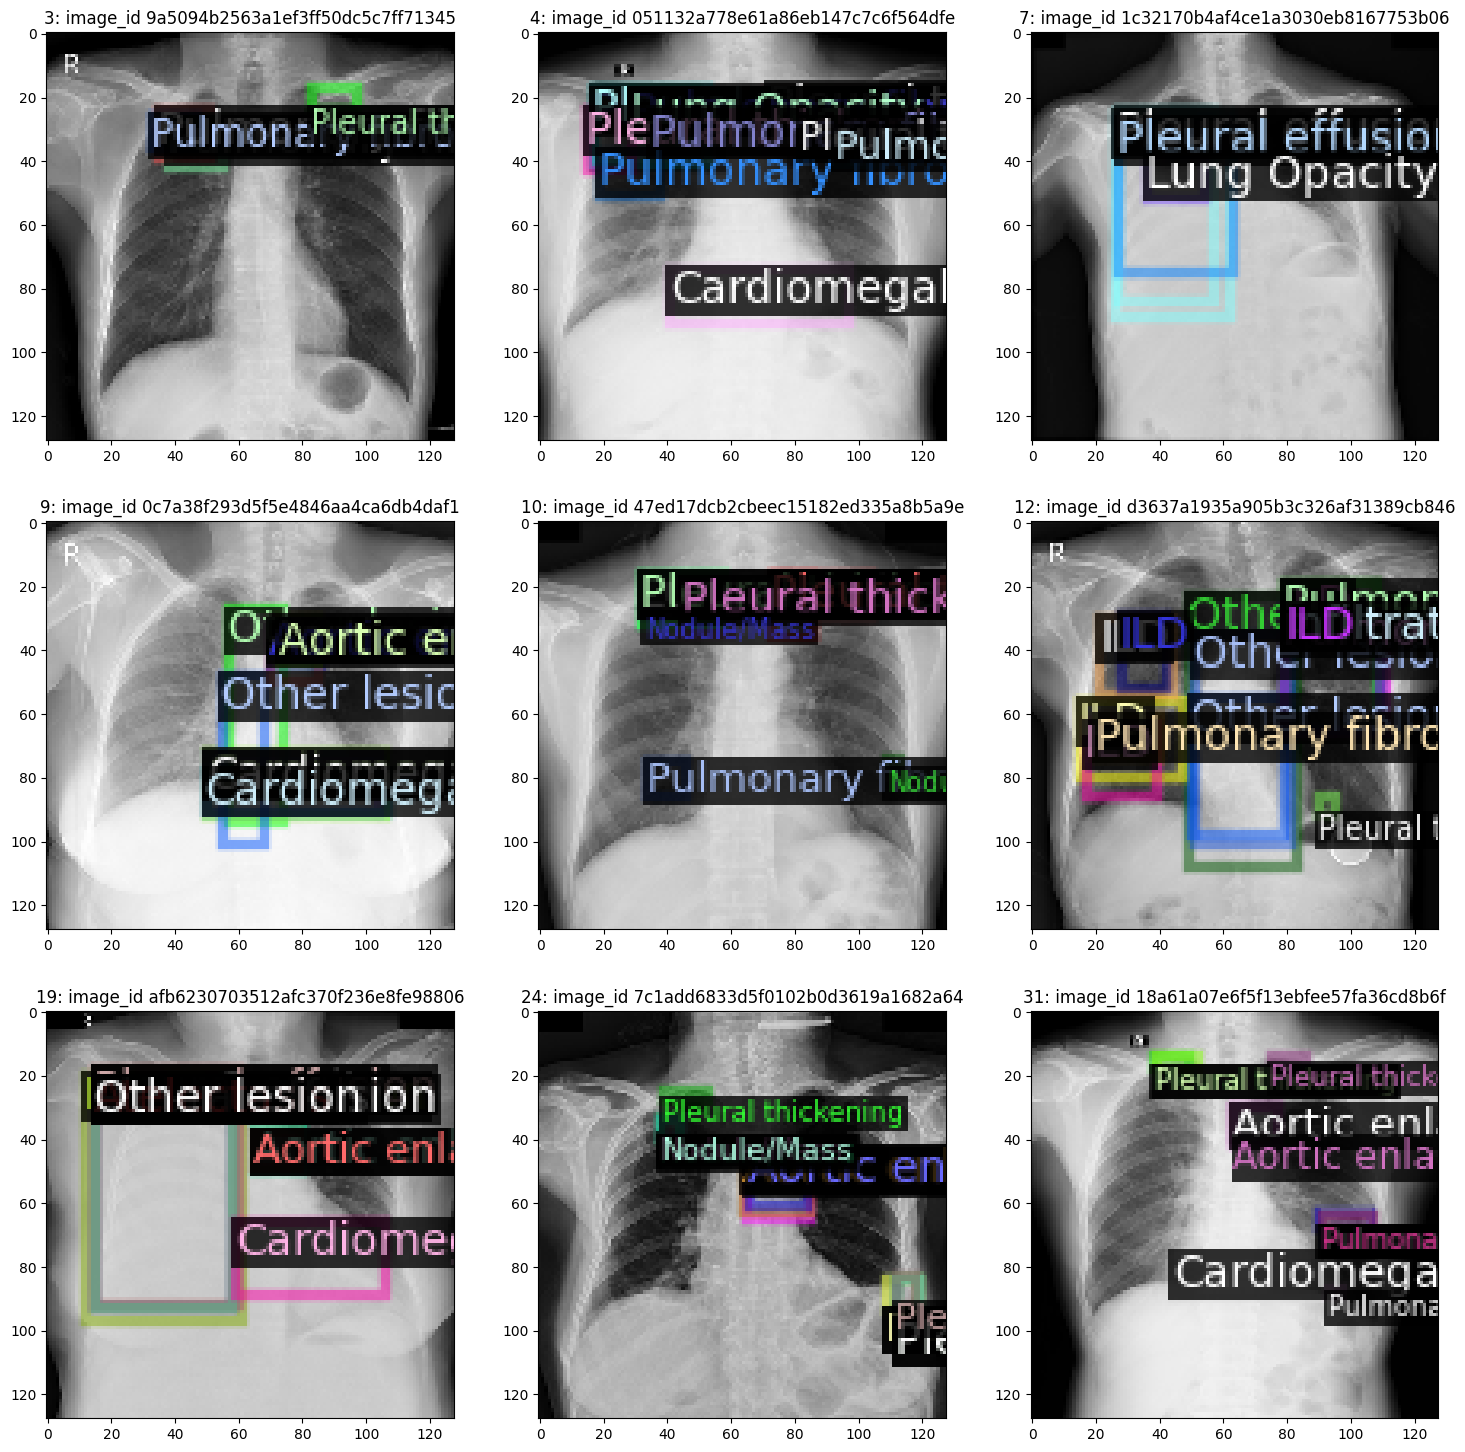

In [ ]:

anomaly_image_ids = train.query("class_id != 14")["image_id"].unique()
train_meta = pd.read_csv(imgdir/"train_meta.csv")
anomaly_inds = np.argwhere(train_meta["image_id"].isin(anomaly_image_ids).values)[:, 0]

vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train")

cols = 3
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for index, anom_ind in enumerate(anomaly_inds[:cols * rows]):
    ax = axes[index]
    # print(anom_ind)
    d = dataset_dicts[anom_ind]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdata_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    #cv2.imwrite(str(outdir / f"vinbigdata{index}.jpg"), out.get_image()[:, :, ::-1])
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(f"{anom_ind}: image_id {anomaly_image_ids[index]}")

In [20]:
from detectron2.config import get_cfg
from detectron2.model_zoo import model_zoo  # Make sure this is correctly imported if used
import os
from detectron2.config.config import CfgNode as CN

def add_swint_config(cfg):
    from detectron2.config import CfgNode as CN
    # SwinT backbone
    cfg.MODEL.SWINT = CN()
    cfg.MODEL.SWINT.EMBED_DIM = 96
    cfg.MODEL.SWINT.OUT_FEATURES = ["stage2", "stage3", "stage4", "stage5"]
    cfg.MODEL.SWINT.DEPTHS = [2, 2, 6, 2]
    cfg.MODEL.SWINT.NUM_HEADS = [3, 6, 12, 24]
    cfg.MODEL.SWINT.WINDOW_SIZE = 7
    cfg.MODEL.SWINT.MLP_RATIO = 4
    cfg.MODEL.SWINT.DROP_PATH_RATE = 0.2
    cfg.MODEL.SWINT.APE = False
    cfg.MODEL.BACKBONE.FREEZE_AT = -1

    # Additional settings
    cfg.MODEL.FPN.TOP_LEVELS = 2
    cfg.SOLVER.OPTIMIZER = "AdamW"

# Initialize configuration and add custom SWINT settings
cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)

add_swint_config(cfg)

# Configuration parameters from the script
original_output_dir = cfg.OUTPUT_DIR
outdir = "./" # Define outdir as needed
cfg.OUTPUT_DIR = "./"
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = os.path.join(imgdir, 'faster_rcnn_swint_T_FPN_3x.yaml')
cfg.merge_from_file(   os.path.join(imgdir, 'Base-RCNN-FPN.yaml')  )

cfg.DATASETS.TRAIN = ("vinbigdata_train",)
cfg.DATASETS.TEST = ("vinbigdata_valid",)
split_mode = flags_dict["split_mode"]  # Define split_mode as needed
if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("vinbigdata_valid",)
    cfg.TEST.EVAL_PERIOD = 400  # Example value, set as needed

# Assuming flags are defined elsewhere, make sure to properly define or replace `flags`
cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/xray_dataset/faster_rcnn_swint_T_convertedetc_model.pth'
#cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/xray_dataset/model_final.pth'
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.OUTPUT_DIR ./output -> ./


In [19]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [21]:
from detectron2.modeling import Backbone, BACKBONE_REGISTRY
import sys
sys.path.append('/content/drive/MyDrive/xray_dataset/')
from swin_transformer import SwinTransformer

In [22]:
import torch
import torch.nn as nn
from detectron2.modeling.backbone import Backbone
from detectron2.modeling.backbone.build import BACKBONE_REGISTRY
from swin_transformer import SwinTransformer

@BACKBONE_REGISTRY.register()
def build_swint_backbone1231(cfg, input_shape):
    return SwinTransformer(
        patch_size=4,
        in_chans=input_shape.channels,
        embed_dim=cfg.MODEL.SWINT.EMBED_DIM,
        depths=cfg.MODEL.SWINT.DEPTHS,
        num_heads=cfg.MODEL.SWINT.NUM_HEADS,
        window_size=cfg.MODEL.SWINT.WINDOW_SIZE,
        mlp_ratio=cfg.MODEL.SWINT.MLP_RATIO,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=cfg.MODEL.SWINT.DROP_PATH_RATE,
        norm_layer=nn.LayerNorm,
        ape=cfg.MODEL.SWINT.APE,
        patch_norm=True,
        out_features= ['stage2', 'stage3', 'stage4', 'stage5']
    )

In [23]:
import os
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return VinbigdataEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)
        return hooks

    @classmethod
    def build_backbone(cls, cfg):
        backbone_name = cfg.MODEL.BACKBONE.NAME
        return build_swint_backbone1231(cfg,input_shape)


In [52]:
from detectron2.data import build_detection_train_loader

# Set up the data loader
train_loader = build_detection_train_loader(cfg)

Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[05/16 08:06:44 d2.data.build]: Removed 10606 images with no usable annotations. 4394 images left.
[05/16 08:06:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/16 08:06:44 d2.data.build]: Using training sampler TrainingSampler
[05/16 08:06:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/16 08:06:44 d2.data.common]: Serializing 4394 elements to byte tensors and concatenating them all ...
[05/16 08:06:44 d2.data.common]: Serialized dataset takes 2.99 MiB
[05/16 08:06:44 d2.data.build]: Making batched data loader with batch_size=2


In [24]:
# Now, you can use MyTrainer to train your model
from detectron2.data import build_detection_train_loader

# Set up the data loader
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()


[05/17 01:39:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

backbone.bottom_up.res2.0.conv1.norm.{bias, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, weight}
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.0.shortcut.norm.{bias, weight}
backbone.bottom_up.res2.0.shortcut.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.norm.{bias, weight}
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.norm.{bias, weight}
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up.res3.0.conv1.norm.{bias, weight}
backbone.bottom_up.res3.0.conv1.

[05/17 01:39:54 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)



[05/17 01:40:04 d2.utils.events]:  eta: 1:05:07  iter: 19  total_loss: 31.01  loss_cls: 20.16  loss_box_reg: 4.715  loss_rpn_cls: 2.691  loss_rpn_loc: 3.015    time: 0.2259  last_time: 0.1876  data_time: 0.0748  last_data_time: 0.0409   lr: 1.9864e-05  max_mem: 1964M
[05/17 01:40:10 d2.utils.events]:  eta: 1:02:23  iter: 39  total_loss: 3.898  loss_cls: 2.07  loss_box_reg: 0.8706  loss_rpn_cls: 0.5494  loss_rpn_loc: 0.4614    time: 0.2135  last_time: 0.1713  data_time: 0.0220  last_data_time: 0.0011   lr: 3.9721e-05  max_mem: 1965M
[05/17 01:40:15 d2.utils.events]:  eta: 1:04:09  iter: 59  total_loss: 1.351  loss_cls: 0.8285  loss_box_reg: 0.2414  loss_rpn_cls: 0.2778  loss_rpn_loc: 0.1186    time: 0.2150  last_time: 0.1319  data_time: 0.0548  last_data_time: 0.0027   lr: 5.9578e-05  max_mem: 1966M
[05/17 01:40:19 d2.utils.events]:  eta: 1:04:17  iter: 79  total_loss: 1.314  loss_cls: 0.7112  loss_box_reg: 0.1789  loss_rpn_cls: 0.2681  loss_rpn_loc: 0.1082    time: 0.2208  last_time: 0

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 01:42:21 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0672 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0951 s/iter. ETA=0:04:44
[05/17 01:42:27 d2.evaluation.evaluator]: Inference done 59/3000. Dataloading: 0.0760 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.1040 s/iter. ETA=0:05:05
[05/17 01:42:32 d2.evaluation.evaluator]: Inference done 106/3000. Dataloading: 0.0772 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.1051 s/iter. ETA=0:05:04
[05/17 01:42:37 d2.evaluation.evaluator]: Inference done 151/3000. Dataloading: 0.0797 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.1083 s/iter. ETA=0:05:08
[05/17 01:42:42 d2.evaluation.evaluator]: Inference done 201/3000. Dataloading: 0.0778 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.1063 s/iter. ETA=0:04:57
[05/17 01:42:47 d2.evaluation.evaluator]: Inference done 239/3000. Dataloading: 0.0820 s/iter. Inference: 0.0279 s/iter. E

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 01:48:41 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:29
[05/17 01:48:46 detectron2]: Loss on Validation  done 141/3000. 0.0001 s / img. ETA=0:01:49
[05/17 01:48:51 detectron2]: Loss on Validation  done 278/3000. 0.0001 s / img. ETA=0:01:41
[05/17 01:48:56 detectron2]: Loss on Validation  done 414/3000. 0.0001 s / img. ETA=0:01:36
[05/17 01:49:01 detectron2]: Loss on Validation  done 550/3000. 0.0001 s / img. ETA=0:01:31
[05/17 01:49:06 detectron2]: Loss on Validation  done 685/3000. 0.0001 s / img. ETA=0:01:26
[05/17 01:49:11 detectron2]: Loss on Validation  done 819/3000. 0.0001 s / img. ETA=0:01:21
[05/17 01:49:16 detectron2]: Loss on Validation  done 958/3000. 0.0001 s / img. ETA=0:01:15
[05/17 01:49:21 detectron2]: Loss on Validation  done 1094/3000. 0.0001 s / img. ETA=0:01:10
[05/17 01:49:26 detectron2]: Loss on Validation  done 1228/3000. 0.0001 s / img. ETA=0:01:05
[05/17 01:49:31 detectron2]: Loss on Validation  done 1365/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 01:52:24 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0275 s/iter. Eval: 0.0003 s/iter. Total: 0.0291 s/iter. ETA=0:01:26
[05/17 01:52:29 d2.evaluation.evaluator]: Inference done 183/3000. Dataloading: 0.0014 s/iter. Inference: 0.0274 s/iter. Eval: 0.0003 s/iter. Total: 0.0291 s/iter. ETA=0:01:22
[05/17 01:52:34 d2.evaluation.evaluator]: Inference done 354/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0003 s/iter. Total: 0.0292 s/iter. ETA=0:01:17
[05/17 01:52:40 d2.evaluation.evaluator]: Inference done 515/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. Eval: 0.0003 s/iter. Total: 0.0298 s/iter. ETA=0:01:14
[05/17 01:52:45 d2.evaluation.evaluator]: Inference done 665/3000. Dataloading: 0.0014 s/iter. Inference: 0.0289 s/iter. Eval: 0.0003 s/iter. Total: 0.0306 s/iter. ETA=0:01:11
[05/17 01:52:50 d2.evaluation.evaluator]: Inference done 835/3000. Dataloading: 0.0014 s/iter. Inference: 0.0286 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 01:54:00 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:31
[05/17 01:54:05 detectron2]: Loss on Validation  done 138/3000. 0.0001 s / img. ETA=0:01:52
[05/17 01:54:10 detectron2]: Loss on Validation  done 270/3000. 0.0001 s / img. ETA=0:01:45
[05/17 01:54:15 detectron2]: Loss on Validation  done 402/3000. 0.0001 s / img. ETA=0:01:39
[05/17 01:54:20 detectron2]: Loss on Validation  done 539/3000. 0.0001 s / img. ETA=0:01:33
[05/17 01:54:25 detectron2]: Loss on Validation  done 669/3000. 0.0001 s / img. ETA=0:01:28
[05/17 01:54:30 detectron2]: Loss on Validation  done 798/3000. 0.0001 s / img. ETA=0:01:24
[05/17 01:54:35 detectron2]: Loss on Validation  done 931/3000. 0.0001 s / img. ETA=0:01:18
[05/17 01:54:40 detectron2]: Loss on Validation  done 1062/3000. 0.0001 s / img. ETA=0:01:13
[05/17 01:54:45 detectron2]: Loss on Validation  done 1190/3000. 0.0001 s / img. ETA=0:01:09
[05/17 01:54:50 detectron2]: Loss on Validation  done 1314/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 01:57:47 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0009 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:26
[05/17 01:57:52 d2.evaluation.evaluator]: Inference done 177/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:25
[05/17 01:57:57 d2.evaluation.evaluator]: Inference done 343/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:20
[05/17 01:58:02 d2.evaluation.evaluator]: Inference done 515/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:14
[05/17 01:58:07 d2.evaluation.evaluator]: Inference done 688/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:08
[05/17 01:58:12 d2.evaluation.evaluator]: Inference done 827/3000. Dataloading: 0.0021 s/iter. Inference: 0.0282 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 01:59:26 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:37
[05/17 01:59:31 detectron2]: Loss on Validation  done 141/3000. 0.0001 s / img. ETA=0:01:49
[05/17 01:59:36 detectron2]: Loss on Validation  done 256/3000. 0.0001 s / img. ETA=0:01:51
[05/17 01:59:41 detectron2]: Loss on Validation  done 390/3000. 0.0001 s / img. ETA=0:01:43
[05/17 01:59:46 detectron2]: Loss on Validation  done 523/3000. 0.0001 s / img. ETA=0:01:36
[05/17 01:59:51 detectron2]: Loss on Validation  done 652/3000. 0.0001 s / img. ETA=0:01:31
[05/17 01:59:56 detectron2]: Loss on Validation  done 782/3000. 0.0001 s / img. ETA=0:01:26
[05/17 02:00:01 detectron2]: Loss on Validation  done 911/3000. 0.0001 s / img. ETA=0:01:21
[05/17 02:00:06 detectron2]: Loss on Validation  done 1039/3000. 0.0001 s / img. ETA=0:01:16
[05/17 02:00:11 detectron2]: Loss on Validation  done 1168/3000. 0.0001 s / img. ETA=0:01:11
[05/17 02:00:16 detectron2]: Loss on Validation  done 1300/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:03:29 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0301 s/iter. Eval: 0.0004 s/iter. Total: 0.0319 s/iter. ETA=0:01:35
[05/17 02:03:34 d2.evaluation.evaluator]: Inference done 180/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:24
[05/17 02:03:39 d2.evaluation.evaluator]: Inference done 343/3000. Dataloading: 0.0014 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0303 s/iter. ETA=0:01:20
[05/17 02:03:44 d2.evaluation.evaluator]: Inference done 512/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. Eval: 0.0004 s/iter. Total: 0.0301 s/iter. ETA=0:01:14
[05/17 02:03:49 d2.evaluation.evaluator]: Inference done 677/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:10
[05/17 02:03:54 d2.evaluation.evaluator]: Inference done 849/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:05:07 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 02:05:12 detectron2]: Loss on Validation  done 142/3000. 0.0001 s / img. ETA=0:01:48
[05/17 02:05:17 detectron2]: Loss on Validation  done 273/3000. 0.0001 s / img. ETA=0:01:44
[05/17 02:05:22 detectron2]: Loss on Validation  done 404/3000. 0.0001 s / img. ETA=0:01:39
[05/17 02:05:27 detectron2]: Loss on Validation  done 531/3000. 0.0001 s / img. ETA=0:01:35
[05/17 02:05:32 detectron2]: Loss on Validation  done 661/3000. 0.0001 s / img. ETA=0:01:30
[05/17 02:05:37 detectron2]: Loss on Validation  done 791/3000. 0.0001 s / img. ETA=0:01:25
[05/17 02:05:42 detectron2]: Loss on Validation  done 921/3000. 0.0001 s / img. ETA=0:01:20
[05/17 02:05:47 detectron2]: Loss on Validation  done 1053/3000. 0.0001 s / img. ETA=0:01:15
[05/17 02:05:53 detectron2]: Loss on Validation  done 1183/3000. 0.0001 s / img. ETA=0:01:10
[05/17 02:05:58 detectron2]: Loss on Validation  done 1308/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:08:26 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0288 s/iter. ETA=0:01:25
[05/17 02:08:31 d2.evaluation.evaluator]: Inference done 178/3000. Dataloading: 0.0014 s/iter. Inference: 0.0272 s/iter. Eval: 0.0034 s/iter. Total: 0.0320 s/iter. ETA=0:01:30
[05/17 02:08:36 d2.evaluation.evaluator]: Inference done 350/3000. Dataloading: 0.0014 s/iter. Inference: 0.0273 s/iter. Eval: 0.0019 s/iter. Total: 0.0306 s/iter. ETA=0:01:21
[05/17 02:08:41 d2.evaluation.evaluator]: Inference done 513/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0014 s/iter. Total: 0.0306 s/iter. ETA=0:01:16
[05/17 02:08:46 d2.evaluation.evaluator]: Inference done 680/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0012 s/iter. Total: 0.0305 s/iter. ETA=0:01:10
[05/17 02:08:51 d2.evaluation.evaluator]: Inference done 846/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:10:04 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:30
[05/17 02:10:09 detectron2]: Loss on Validation  done 144/3000. 0.0001 s / img. ETA=0:01:46
[05/17 02:10:14 detectron2]: Loss on Validation  done 275/3000. 0.0001 s / img. ETA=0:01:42
[05/17 02:10:19 detectron2]: Loss on Validation  done 411/3000. 0.0001 s / img. ETA=0:01:37
[05/17 02:10:24 detectron2]: Loss on Validation  done 545/3000. 0.0001 s / img. ETA=0:01:32
[05/17 02:10:29 detectron2]: Loss on Validation  done 678/3000. 0.0001 s / img. ETA=0:01:27
[05/17 02:10:34 detectron2]: Loss on Validation  done 811/3000. 0.0001 s / img. ETA=0:01:22
[05/17 02:10:39 detectron2]: Loss on Validation  done 946/3000. 0.0001 s / img. ETA=0:01:17
[05/17 02:10:44 detectron2]: Loss on Validation  done 1082/3000. 0.0001 s / img. ETA=0:01:11
[05/17 02:10:49 detectron2]: Loss on Validation  done 1214/3000. 0.0001 s / img. ETA=0:01:07
[05/17 02:10:54 detectron2]: Loss on Validation  done 1346/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:13:08 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:27
[05/17 02:13:13 d2.evaluation.evaluator]: Inference done 174/3000. Dataloading: 0.0014 s/iter. Inference: 0.0289 s/iter. Eval: 0.0004 s/iter. Total: 0.0308 s/iter. ETA=0:01:27
[05/17 02:13:18 d2.evaluation.evaluator]: Inference done 322/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. Eval: 0.0023 s/iter. Total: 0.0323 s/iter. ETA=0:01:26
[05/17 02:13:23 d2.evaluation.evaluator]: Inference done 496/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0016 s/iter. Total: 0.0311 s/iter. ETA=0:01:17
[05/17 02:13:28 d2.evaluation.evaluator]: Inference done 666/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0013 s/iter. Total: 0.0306 s/iter. ETA=0:01:11
[05/17 02:13:33 d2.evaluation.evaluator]: Inference done 831/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:14:48 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:37
[05/17 02:14:53 detectron2]: Loss on Validation  done 139/3000. 0.0001 s / img. ETA=0:01:50
[05/17 02:14:58 detectron2]: Loss on Validation  done 274/3000. 0.0001 s / img. ETA=0:01:43
[05/17 02:15:03 detectron2]: Loss on Validation  done 407/3000. 0.0001 s / img. ETA=0:01:38
[05/17 02:15:08 detectron2]: Loss on Validation  done 537/3000. 0.0001 s / img. ETA=0:01:33
[05/17 02:15:13 detectron2]: Loss on Validation  done 670/3000. 0.0001 s / img. ETA=0:01:28
[05/17 02:15:18 detectron2]: Loss on Validation  done 805/3000. 0.0001 s / img. ETA=0:01:23
[05/17 02:15:23 detectron2]: Loss on Validation  done 940/3000. 0.0001 s / img. ETA=0:01:17
[05/17 02:15:28 detectron2]: Loss on Validation  done 1069/3000. 0.0001 s / img. ETA=0:01:13
[05/17 02:15:33 detectron2]: Loss on Validation  done 1201/3000. 0.0001 s / img. ETA=0:01:08
[05/17 02:15:38 detectron2]: Loss on Validation  done 1336/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:17:53 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:28
[05/17 02:17:58 d2.evaluation.evaluator]: Inference done 168/3000. Dataloading: 0.0014 s/iter. Inference: 0.0307 s/iter. Eval: 0.0004 s/iter. Total: 0.0326 s/iter. ETA=0:01:32
[05/17 02:18:03 d2.evaluation.evaluator]: Inference done 343/3000. Dataloading: 0.0014 s/iter. Inference: 0.0287 s/iter. Eval: 0.0004 s/iter. Total: 0.0305 s/iter. ETA=0:01:21
[05/17 02:18:08 d2.evaluation.evaluator]: Inference done 511/3000. Dataloading: 0.0014 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0303 s/iter. ETA=0:01:15
[05/17 02:18:13 d2.evaluation.evaluator]: Inference done 678/3000. Dataloading: 0.0014 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:10
[05/17 02:18:18 d2.evaluation.evaluator]: Inference done 848/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:19:32 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:29
[05/17 02:19:37 detectron2]: Loss on Validation  done 146/3000. 0.0001 s / img. ETA=0:01:45
[05/17 02:19:42 detectron2]: Loss on Validation  done 283/3000. 0.0001 s / img. ETA=0:01:39
[05/17 02:19:47 detectron2]: Loss on Validation  done 418/3000. 0.0001 s / img. ETA=0:01:35
[05/17 02:19:52 detectron2]: Loss on Validation  done 557/3000. 0.0001 s / img. ETA=0:01:29
[05/17 02:19:57 detectron2]: Loss on Validation  done 693/3000. 0.0001 s / img. ETA=0:01:24
[05/17 02:20:02 detectron2]: Loss on Validation  done 828/3000. 0.0001 s / img. ETA=0:01:19
[05/17 02:20:07 detectron2]: Loss on Validation  done 962/3000. 0.0001 s / img. ETA=0:01:15
[05/17 02:20:12 detectron2]: Loss on Validation  done 1093/3000. 0.0001 s / img. ETA=0:01:10
[05/17 02:20:17 detectron2]: Loss on Validation  done 1227/3000. 0.0001 s / img. ETA=0:01:05
[05/17 02:20:22 detectron2]: Loss on Validation  done 1357/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:22:36 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0288 s/iter. ETA=0:01:26
[05/17 02:22:41 d2.evaluation.evaluator]: Inference done 182/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:22
[05/17 02:22:46 d2.evaluation.evaluator]: Inference done 349/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:18
[05/17 02:22:51 d2.evaluation.evaluator]: Inference done 522/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:12
[05/17 02:22:56 d2.evaluation.evaluator]: Inference done 687/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:08
[05/17 02:23:01 d2.evaluation.evaluator]: Inference done 850/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:24:14 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 02:24:19 detectron2]: Loss on Validation  done 138/3000. 0.0001 s / img. ETA=0:01:51
[05/17 02:24:24 detectron2]: Loss on Validation  done 268/3000. 0.0001 s / img. ETA=0:01:46
[05/17 02:24:29 detectron2]: Loss on Validation  done 400/3000. 0.0001 s / img. ETA=0:01:40
[05/17 02:24:34 detectron2]: Loss on Validation  done 532/3000. 0.0001 s / img. ETA=0:01:34
[05/17 02:24:39 detectron2]: Loss on Validation  done 663/3000. 0.0001 s / img. ETA=0:01:29
[05/17 02:24:44 detectron2]: Loss on Validation  done 794/3000. 0.0001 s / img. ETA=0:01:24
[05/17 02:24:49 detectron2]: Loss on Validation  done 924/3000. 0.0001 s / img. ETA=0:01:19
[05/17 02:24:54 detectron2]: Loss on Validation  done 1057/3000. 0.0001 s / img. ETA=0:01:14
[05/17 02:24:59 detectron2]: Loss on Validation  done 1192/3000. 0.0001 s / img. ETA=0:01:09
[05/17 02:25:04 detectron2]: Loss on Validation  done 1323/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:27:19 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0324 s/iter. Eval: 0.0004 s/iter. Total: 0.0341 s/iter. ETA=0:01:41
[05/17 02:27:24 d2.evaluation.evaluator]: Inference done 172/3000. Dataloading: 0.0015 s/iter. Inference: 0.0293 s/iter. Eval: 0.0004 s/iter. Total: 0.0313 s/iter. ETA=0:01:28
[05/17 02:27:29 d2.evaluation.evaluator]: Inference done 338/3000. Dataloading: 0.0015 s/iter. Inference: 0.0288 s/iter. Eval: 0.0004 s/iter. Total: 0.0308 s/iter. ETA=0:01:21
[05/17 02:27:34 d2.evaluation.evaluator]: Inference done 507/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. Eval: 0.0004 s/iter. Total: 0.0304 s/iter. ETA=0:01:15
[05/17 02:27:39 d2.evaluation.evaluator]: Inference done 679/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. Eval: 0.0004 s/iter. Total: 0.0301 s/iter. ETA=0:01:09
[05/17 02:27:44 d2.evaluation.evaluator]: Inference done 849/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:29:00 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 02:29:05 detectron2]: Loss on Validation  done 143/3000. 0.0001 s / img. ETA=0:01:47
[05/17 02:29:10 detectron2]: Loss on Validation  done 275/3000. 0.0001 s / img. ETA=0:01:43
[05/17 02:29:15 detectron2]: Loss on Validation  done 405/3000. 0.0001 s / img. ETA=0:01:38
[05/17 02:29:20 detectron2]: Loss on Validation  done 537/3000. 0.0001 s / img. ETA=0:01:33
[05/17 02:29:25 detectron2]: Loss on Validation  done 668/3000. 0.0001 s / img. ETA=0:01:28
[05/17 02:29:30 detectron2]: Loss on Validation  done 796/3000. 0.0001 s / img. ETA=0:01:24
[05/17 02:29:35 detectron2]: Loss on Validation  done 930/3000. 0.0001 s / img. ETA=0:01:18
[05/17 02:29:40 detectron2]: Loss on Validation  done 1066/3000. 0.0001 s / img. ETA=0:01:13
[05/17 02:29:45 detectron2]: Loss on Validation  done 1203/3000. 0.0001 s / img. ETA=0:01:08
[05/17 02:29:50 detectron2]: Loss on Validation  done 1333/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:32:05 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0272 s/iter. Eval: 0.0004 s/iter. Total: 0.0288 s/iter. ETA=0:01:26
[05/17 02:32:10 d2.evaluation.evaluator]: Inference done 180/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:23
[05/17 02:32:15 d2.evaluation.evaluator]: Inference done 347/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:19
[05/17 02:32:20 d2.evaluation.evaluator]: Inference done 520/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:13
[05/17 02:32:25 d2.evaluation.evaluator]: Inference done 690/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:08
[05/17 02:32:30 d2.evaluation.evaluator]: Inference done 858/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:33:43 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:39
[05/17 02:33:48 detectron2]: Loss on Validation  done 134/3000. 0.0001 s / img. ETA=0:01:55
[05/17 02:33:53 detectron2]: Loss on Validation  done 265/3000. 0.0001 s / img. ETA=0:01:47
[05/17 02:33:58 detectron2]: Loss on Validation  done 396/3000. 0.0001 s / img. ETA=0:01:41
[05/17 02:34:03 detectron2]: Loss on Validation  done 526/3000. 0.0001 s / img. ETA=0:01:36
[05/17 02:34:08 detectron2]: Loss on Validation  done 653/3000. 0.0001 s / img. ETA=0:01:31
[05/17 02:34:13 detectron2]: Loss on Validation  done 786/3000. 0.0001 s / img. ETA=0:01:26
[05/17 02:34:18 detectron2]: Loss on Validation  done 918/3000. 0.0001 s / img. ETA=0:01:20
[05/17 02:34:23 detectron2]: Loss on Validation  done 1047/3000. 0.0001 s / img. ETA=0:01:15
[05/17 02:34:28 detectron2]: Loss on Validation  done 1169/3000. 0.0001 s / img. ETA=0:01:11
[05/17 02:34:33 detectron2]: Loss on Validation  done 1299/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:36:50 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:30
[05/17 02:36:55 d2.evaluation.evaluator]: Inference done 176/3000. Dataloading: 0.0016 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0304 s/iter. ETA=0:01:25
[05/17 02:37:00 d2.evaluation.evaluator]: Inference done 346/3000. Dataloading: 0.0015 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:19
[05/17 02:37:05 d2.evaluation.evaluator]: Inference done 516/3000. Dataloading: 0.0015 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:14
[05/17 02:37:10 d2.evaluation.evaluator]: Inference done 683/3000. Dataloading: 0.0015 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:09
[05/17 02:37:15 d2.evaluation.evaluator]: Inference done 850/3000. Dataloading: 0.0015 s/iter. Inference: 0.0280 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:38:29 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 02:38:34 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:50
[05/17 02:38:39 detectron2]: Loss on Validation  done 269/3000. 0.0001 s / img. ETA=0:01:45
[05/17 02:38:44 detectron2]: Loss on Validation  done 397/3000. 0.0001 s / img. ETA=0:01:41
[05/17 02:38:49 detectron2]: Loss on Validation  done 525/3000. 0.0001 s / img. ETA=0:01:36
[05/17 02:38:54 detectron2]: Loss on Validation  done 655/3000. 0.0001 s / img. ETA=0:01:31
[05/17 02:38:59 detectron2]: Loss on Validation  done 780/3000. 0.0001 s / img. ETA=0:01:26
[05/17 02:39:04 detectron2]: Loss on Validation  done 913/3000. 0.0001 s / img. ETA=0:01:21
[05/17 02:39:09 detectron2]: Loss on Validation  done 1047/3000. 0.0001 s / img. ETA=0:01:15
[05/17 02:39:14 detectron2]: Loss on Validation  done 1175/3000. 0.0001 s / img. ETA=0:01:10
[05/17 02:39:19 detectron2]: Loss on Validation  done 1305/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:41:35 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0292 s/iter. ETA=0:01:27
[05/17 02:41:40 d2.evaluation.evaluator]: Inference done 183/3000. Dataloading: 0.0014 s/iter. Inference: 0.0273 s/iter. Eval: 0.0004 s/iter. Total: 0.0292 s/iter. ETA=0:01:22
[05/17 02:41:45 d2.evaluation.evaluator]: Inference done 349/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:18
[05/17 02:41:51 d2.evaluation.evaluator]: Inference done 517/3000. Dataloading: 0.0014 s/iter. Inference: 0.0288 s/iter. Eval: 0.0004 s/iter. Total: 0.0307 s/iter. ETA=0:01:16
[05/17 02:41:56 d2.evaluation.evaluator]: Inference done 680/3000. Dataloading: 0.0014 s/iter. Inference: 0.0288 s/iter. Eval: 0.0004 s/iter. Total: 0.0307 s/iter. ETA=0:01:11
[05/17 02:42:01 d2.evaluation.evaluator]: Inference done 843/3000. Dataloading: 0.0014 s/iter. Inference: 0.0288 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:43:15 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:37
[05/17 02:43:20 detectron2]: Loss on Validation  done 145/3000. 0.0001 s / img. ETA=0:01:46
[05/17 02:43:25 detectron2]: Loss on Validation  done 273/3000. 0.0001 s / img. ETA=0:01:44
[05/17 02:43:30 detectron2]: Loss on Validation  done 405/3000. 0.0001 s / img. ETA=0:01:38
[05/17 02:43:35 detectron2]: Loss on Validation  done 532/3000. 0.0001 s / img. ETA=0:01:34
[05/17 02:43:40 detectron2]: Loss on Validation  done 666/3000. 0.0001 s / img. ETA=0:01:29
[05/17 02:43:45 detectron2]: Loss on Validation  done 799/3000. 0.0001 s / img. ETA=0:01:23
[05/17 02:43:50 detectron2]: Loss on Validation  done 932/3000. 0.0001 s / img. ETA=0:01:18
[05/17 02:43:55 detectron2]: Loss on Validation  done 1064/3000. 0.0001 s / img. ETA=0:01:13
[05/17 02:44:00 detectron2]: Loss on Validation  done 1196/3000. 0.0001 s / img. ETA=0:01:08
[05/17 02:44:05 detectron2]: Loss on Validation  done 1328/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:46:20 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:28
[05/17 02:46:25 d2.evaluation.evaluator]: Inference done 180/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:23
[05/17 02:46:30 d2.evaluation.evaluator]: Inference done 351/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:18
[05/17 02:46:35 d2.evaluation.evaluator]: Inference done 517/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:13
[05/17 02:46:40 d2.evaluation.evaluator]: Inference done 681/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:09
[05/17 02:46:45 d2.evaluation.evaluator]: Inference done 832/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:47:59 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:32
[05/17 02:48:04 detectron2]: Loss on Validation  done 142/3000. 0.0001 s / img. ETA=0:01:48
[05/17 02:48:09 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 02:48:14 detectron2]: Loss on Validation  done 404/3000. 0.0001 s / img. ETA=0:01:39
[05/17 02:48:19 detectron2]: Loss on Validation  done 537/3000. 0.0001 s / img. ETA=0:01:34
[05/17 02:48:24 detectron2]: Loss on Validation  done 670/3000. 0.0001 s / img. ETA=0:01:28
[05/17 02:48:29 detectron2]: Loss on Validation  done 803/3000. 0.0001 s / img. ETA=0:01:23
[05/17 02:48:34 detectron2]: Loss on Validation  done 939/3000. 0.0001 s / img. ETA=0:01:18
[05/17 02:48:39 detectron2]: Loss on Validation  done 1074/3000. 0.0001 s / img. ETA=0:01:12
[05/17 02:48:44 detectron2]: Loss on Validation  done 1206/3000. 0.0001 s / img. ETA=0:01:07
[05/17 02:48:49 detectron2]: Loss on Validation  done 1338/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:51:03 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0021 s/iter. Inference: 0.0268 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:27
[05/17 02:51:08 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0015 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:23
[05/17 02:51:13 d2.evaluation.evaluator]: Inference done 354/3000. Dataloading: 0.0015 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0292 s/iter. ETA=0:01:17
[05/17 02:51:18 d2.evaluation.evaluator]: Inference done 526/3000. Dataloading: 0.0015 s/iter. Inference: 0.0273 s/iter. Eval: 0.0004 s/iter. Total: 0.0292 s/iter. ETA=0:01:12
[05/17 02:51:23 d2.evaluation.evaluator]: Inference done 697/3000. Dataloading: 0.0015 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:07
[05/17 02:51:28 d2.evaluation.evaluator]: Inference done 867/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:52:39 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 02:52:44 detectron2]: Loss on Validation  done 144/3000. 0.0001 s / img. ETA=0:01:47
[05/17 02:52:49 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 02:52:54 detectron2]: Loss on Validation  done 406/3000. 0.0001 s / img. ETA=0:01:38
[05/17 02:52:59 detectron2]: Loss on Validation  done 534/3000. 0.0001 s / img. ETA=0:01:34
[05/17 02:53:04 detectron2]: Loss on Validation  done 663/3000. 0.0001 s / img. ETA=0:01:29
[05/17 02:53:09 detectron2]: Loss on Validation  done 797/3000. 0.0001 s / img. ETA=0:01:24
[05/17 02:53:14 detectron2]: Loss on Validation  done 932/3000. 0.0001 s / img. ETA=0:01:18
[05/17 02:53:19 detectron2]: Loss on Validation  done 1064/3000. 0.0001 s / img. ETA=0:01:13
[05/17 02:53:24 detectron2]: Loss on Validation  done 1192/3000. 0.0001 s / img. ETA=0:01:09
[05/17 02:53:29 detectron2]: Loss on Validation  done 1322/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:55:45 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0264 s/iter. Eval: 0.0004 s/iter. Total: 0.0280 s/iter. ETA=0:01:23
[05/17 02:55:50 d2.evaluation.evaluator]: Inference done 178/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:24
[05/17 02:55:55 d2.evaluation.evaluator]: Inference done 349/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:18
[05/17 02:56:00 d2.evaluation.evaluator]: Inference done 514/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:14
[05/17 02:56:05 d2.evaluation.evaluator]: Inference done 678/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:09
[05/17 02:56:10 d2.evaluation.evaluator]: Inference done 842/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 02:57:22 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:52
[05/17 02:57:27 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:51
[05/17 02:57:32 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 02:57:37 detectron2]: Loss on Validation  done 403/3000. 0.0001 s / img. ETA=0:01:39
[05/17 02:57:42 detectron2]: Loss on Validation  done 534/3000. 0.0001 s / img. ETA=0:01:34
[05/17 02:57:47 detectron2]: Loss on Validation  done 670/3000. 0.0001 s / img. ETA=0:01:28
[05/17 02:57:52 detectron2]: Loss on Validation  done 802/3000. 0.0001 s / img. ETA=0:01:23
[05/17 02:57:57 detectron2]: Loss on Validation  done 929/3000. 0.0001 s / img. ETA=0:01:19
[05/17 02:58:02 detectron2]: Loss on Validation  done 1059/3000. 0.0001 s / img. ETA=0:01:14
[05/17 02:58:07 detectron2]: Loss on Validation  done 1188/3000. 0.0001 s / img. ETA=0:01:09
[05/17 02:58:12 detectron2]: Loss on Validation  done 1313/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:00:28 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0327 s/iter. Eval: 0.0005 s/iter. Total: 0.0346 s/iter. ETA=0:01:43
[05/17 03:00:33 d2.evaluation.evaluator]: Inference done 175/3000. Dataloading: 0.0015 s/iter. Inference: 0.0288 s/iter. Eval: 0.0004 s/iter. Total: 0.0307 s/iter. ETA=0:01:26
[05/17 03:00:38 d2.evaluation.evaluator]: Inference done 345/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:20
[05/17 03:00:43 d2.evaluation.evaluator]: Inference done 512/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. Eval: 0.0004 s/iter. Total: 0.0301 s/iter. ETA=0:01:14
[05/17 03:00:48 d2.evaluation.evaluator]: Inference done 676/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:10
[05/17 03:00:53 d2.evaluation.evaluator]: Inference done 844/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:02:06 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:02:11 detectron2]: Loss on Validation  done 143/3000. 0.0001 s / img. ETA=0:01:48
[05/17 03:02:16 detectron2]: Loss on Validation  done 271/3000. 0.0001 s / img. ETA=0:01:45
[05/17 03:02:21 detectron2]: Loss on Validation  done 406/3000. 0.0001 s / img. ETA=0:01:38
[05/17 03:02:26 detectron2]: Loss on Validation  done 536/3000. 0.0001 s / img. ETA=0:01:34
[05/17 03:02:31 detectron2]: Loss on Validation  done 667/3000. 0.0001 s / img. ETA=0:01:29
[05/17 03:02:36 detectron2]: Loss on Validation  done 794/3000. 0.0001 s / img. ETA=0:01:24
[05/17 03:02:41 detectron2]: Loss on Validation  done 927/3000. 0.0001 s / img. ETA=0:01:19
[05/17 03:02:46 detectron2]: Loss on Validation  done 1054/3000. 0.0001 s / img. ETA=0:01:14
[05/17 03:02:51 detectron2]: Loss on Validation  done 1180/3000. 0.0001 s / img. ETA=0:01:10
[05/17 03:02:56 detectron2]: Loss on Validation  done 1304/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:05:12 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:28
[05/17 03:05:17 d2.evaluation.evaluator]: Inference done 182/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0003 s/iter. Total: 0.0293 s/iter. ETA=0:01:22
[05/17 03:05:22 d2.evaluation.evaluator]: Inference done 341/3000. Dataloading: 0.0015 s/iter. Inference: 0.0284 s/iter. Eval: 0.0003 s/iter. Total: 0.0303 s/iter. ETA=0:01:20
[05/17 03:05:27 d2.evaluation.evaluator]: Inference done 511/3000. Dataloading: 0.0015 s/iter. Inference: 0.0282 s/iter. Eval: 0.0003 s/iter. Total: 0.0300 s/iter. ETA=0:01:14
[05/17 03:05:32 d2.evaluation.evaluator]: Inference done 679/3000. Dataloading: 0.0015 s/iter. Inference: 0.0282 s/iter. Eval: 0.0003 s/iter. Total: 0.0300 s/iter. ETA=0:01:09
[05/17 03:05:37 d2.evaluation.evaluator]: Inference done 848/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:06:47 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:37
[05/17 03:06:52 detectron2]: Loss on Validation  done 136/3000. 0.0001 s / img. ETA=0:01:54
[05/17 03:06:57 detectron2]: Loss on Validation  done 262/3000. 0.0001 s / img. ETA=0:01:49
[05/17 03:07:02 detectron2]: Loss on Validation  done 393/3000. 0.0001 s / img. ETA=0:01:42
[05/17 03:07:07 detectron2]: Loss on Validation  done 528/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:07:12 detectron2]: Loss on Validation  done 652/3000. 0.0001 s / img. ETA=0:01:31
[05/17 03:07:17 detectron2]: Loss on Validation  done 781/3000. 0.0001 s / img. ETA=0:01:26
[05/17 03:07:22 detectron2]: Loss on Validation  done 909/3000. 0.0001 s / img. ETA=0:01:21
[05/17 03:07:27 detectron2]: Loss on Validation  done 1035/3000. 0.0001 s / img. ETA=0:01:17
[05/17 03:07:32 detectron2]: Loss on Validation  done 1165/3000. 0.0001 s / img. ETA=0:01:11
[05/17 03:07:38 detectron2]: Loss on Validation  done 1291/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:09:54 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0015 s/iter. Inference: 0.0297 s/iter. Eval: 0.0004 s/iter. Total: 0.0316 s/iter. ETA=0:01:34
[05/17 03:09:59 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:23
[05/17 03:10:04 d2.evaluation.evaluator]: Inference done 348/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:19
[05/17 03:10:09 d2.evaluation.evaluator]: Inference done 499/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0015 s/iter. Total: 0.0309 s/iter. ETA=0:01:17
[05/17 03:10:14 d2.evaluation.evaluator]: Inference done 668/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0012 s/iter. Total: 0.0306 s/iter. ETA=0:01:11
[05/17 03:10:19 d2.evaluation.evaluator]: Inference done 830/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:11:33 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:02:06
[05/17 03:11:38 detectron2]: Loss on Validation  done 139/3000. 0.0001 s / img. ETA=0:01:52
[05/17 03:11:43 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 03:11:48 detectron2]: Loss on Validation  done 402/3000. 0.0001 s / img. ETA=0:01:40
[05/17 03:11:53 detectron2]: Loss on Validation  done 530/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:11:58 detectron2]: Loss on Validation  done 659/3000. 0.0001 s / img. ETA=0:01:30
[05/17 03:12:03 detectron2]: Loss on Validation  done 789/3000. 0.0001 s / img. ETA=0:01:25
[05/17 03:12:08 detectron2]: Loss on Validation  done 912/3000. 0.0001 s / img. ETA=0:01:21
[05/17 03:12:13 detectron2]: Loss on Validation  done 1038/3000. 0.0001 s / img. ETA=0:01:16
[05/17 03:12:18 detectron2]: Loss on Validation  done 1165/3000. 0.0001 s / img. ETA=0:01:11
[05/17 03:12:23 detectron2]: Loss on Validation  done 1297/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:14:39 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0314 s/iter. Eval: 0.0005 s/iter. Total: 0.0333 s/iter. ETA=0:01:39
[05/17 03:14:44 d2.evaluation.evaluator]: Inference done 180/3000. Dataloading: 0.0015 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:24
[05/17 03:14:49 d2.evaluation.evaluator]: Inference done 352/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:18
[05/17 03:14:55 d2.evaluation.evaluator]: Inference done 519/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:13
[05/17 03:15:00 d2.evaluation.evaluator]: Inference done 684/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:09
[05/17 03:15:05 d2.evaluation.evaluator]: Inference done 856/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:16:18 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:16:23 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:50
[05/17 03:16:29 detectron2]: Loss on Validation  done 266/3000. 0.0001 s / img. ETA=0:01:47
[05/17 03:16:34 detectron2]: Loss on Validation  done 398/3000. 0.0001 s / img. ETA=0:01:41
[05/17 03:16:39 detectron2]: Loss on Validation  done 531/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:16:44 detectron2]: Loss on Validation  done 661/3000. 0.0001 s / img. ETA=0:01:30
[05/17 03:16:49 detectron2]: Loss on Validation  done 783/3000. 0.0001 s / img. ETA=0:01:26
[05/17 03:16:54 detectron2]: Loss on Validation  done 902/3000. 0.0001 s / img. ETA=0:01:22
[05/17 03:16:59 detectron2]: Loss on Validation  done 1034/3000. 0.0001 s / img. ETA=0:01:17
[05/17 03:17:04 detectron2]: Loss on Validation  done 1157/3000. 0.0001 s / img. ETA=0:01:12
[05/17 03:17:09 detectron2]: Loss on Validation  done 1288/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:19:26 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:27
[05/17 03:19:31 d2.evaluation.evaluator]: Inference done 182/3000. Dataloading: 0.0015 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:22
[05/17 03:19:36 d2.evaluation.evaluator]: Inference done 352/3000. Dataloading: 0.0015 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:17
[05/17 03:19:41 d2.evaluation.evaluator]: Inference done 524/3000. Dataloading: 0.0015 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:12
[05/17 03:19:46 d2.evaluation.evaluator]: Inference done 695/3000. Dataloading: 0.0014 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:07
[05/17 03:19:51 d2.evaluation.evaluator]: Inference done 863/3000. Dataloading: 0.0015 s/iter. Inference: 0.0275 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:21:02 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:39
[05/17 03:21:07 detectron2]: Loss on Validation  done 135/3000. 0.0001 s / img. ETA=0:01:54
[05/17 03:21:12 detectron2]: Loss on Validation  done 265/3000. 0.0001 s / img. ETA=0:01:47
[05/17 03:21:17 detectron2]: Loss on Validation  done 396/3000. 0.0001 s / img. ETA=0:01:41
[05/17 03:21:22 detectron2]: Loss on Validation  done 527/3000. 0.0001 s / img. ETA=0:01:36
[05/17 03:21:27 detectron2]: Loss on Validation  done 656/3000. 0.0001 s / img. ETA=0:01:31
[05/17 03:21:32 detectron2]: Loss on Validation  done 789/3000. 0.0001 s / img. ETA=0:01:25
[05/17 03:21:38 detectron2]: Loss on Validation  done 923/3000. 0.0001 s / img. ETA=0:01:20
[05/17 03:21:43 detectron2]: Loss on Validation  done 1055/3000. 0.0001 s / img. ETA=0:01:14
[05/17 03:21:48 detectron2]: Loss on Validation  done 1189/3000. 0.0001 s / img. ETA=0:01:09
[05/17 03:21:53 detectron2]: Loss on Validation  done 1320/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:24:08 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0271 s/iter. Eval: 0.0007 s/iter. Total: 0.0291 s/iter. ETA=0:01:26
[05/17 03:24:13 d2.evaluation.evaluator]: Inference done 180/3000. Dataloading: 0.0015 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:23
[05/17 03:24:18 d2.evaluation.evaluator]: Inference done 334/3000. Dataloading: 0.0031 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0310 s/iter. ETA=0:01:22
[05/17 03:24:23 d2.evaluation.evaluator]: Inference done 508/3000. Dataloading: 0.0025 s/iter. Inference: 0.0273 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:15
[05/17 03:24:28 d2.evaluation.evaluator]: Inference done 677/3000. Dataloading: 0.0022 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0301 s/iter. ETA=0:01:09
[05/17 03:24:33 d2.evaluation.evaluator]: Inference done 846/3000. Dataloading: 0.0021 s/iter. Inference: 0.0275 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:25:45 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:25:50 detectron2]: Loss on Validation  done 141/3000. 0.0001 s / img. ETA=0:01:49
[05/17 03:25:55 detectron2]: Loss on Validation  done 275/3000. 0.0001 s / img. ETA=0:01:43
[05/17 03:26:00 detectron2]: Loss on Validation  done 406/3000. 0.0001 s / img. ETA=0:01:38
[05/17 03:26:05 detectron2]: Loss on Validation  done 538/3000. 0.0001 s / img. ETA=0:01:33
[05/17 03:26:10 detectron2]: Loss on Validation  done 672/3000. 0.0001 s / img. ETA=0:01:28
[05/17 03:26:15 detectron2]: Loss on Validation  done 801/3000. 0.0001 s / img. ETA=0:01:23
[05/17 03:26:20 detectron2]: Loss on Validation  done 931/3000. 0.0001 s / img. ETA=0:01:18
[05/17 03:26:25 detectron2]: Loss on Validation  done 1065/3000. 0.0001 s / img. ETA=0:01:13
[05/17 03:26:30 detectron2]: Loss on Validation  done 1197/3000. 0.0001 s / img. ETA=0:01:08
[05/17 03:26:35 detectron2]: Loss on Validation  done 1326/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:28:50 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:29
[05/17 03:28:55 d2.evaluation.evaluator]: Inference done 176/3000. Dataloading: 0.0015 s/iter. Inference: 0.0285 s/iter. Eval: 0.0004 s/iter. Total: 0.0304 s/iter. ETA=0:01:25
[05/17 03:29:00 d2.evaluation.evaluator]: Inference done 346/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:19
[05/17 03:29:05 d2.evaluation.evaluator]: Inference done 515/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:14
[05/17 03:29:10 d2.evaluation.evaluator]: Inference done 682/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:09
[05/17 03:29:15 d2.evaluation.evaluator]: Inference done 852/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:30:28 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 03:30:33 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:50
[05/17 03:30:38 detectron2]: Loss on Validation  done 271/3000. 0.0001 s / img. ETA=0:01:44
[05/17 03:30:43 detectron2]: Loss on Validation  done 403/3000. 0.0001 s / img. ETA=0:01:39
[05/17 03:30:48 detectron2]: Loss on Validation  done 535/3000. 0.0001 s / img. ETA=0:01:34
[05/17 03:30:53 detectron2]: Loss on Validation  done 665/3000. 0.0001 s / img. ETA=0:01:29
[05/17 03:30:58 detectron2]: Loss on Validation  done 799/3000. 0.0001 s / img. ETA=0:01:24
[05/17 03:31:03 detectron2]: Loss on Validation  done 931/3000. 0.0001 s / img. ETA=0:01:18
[05/17 03:31:08 detectron2]: Loss on Validation  done 1064/3000. 0.0001 s / img. ETA=0:01:13
[05/17 03:31:13 detectron2]: Loss on Validation  done 1194/3000. 0.0001 s / img. ETA=0:01:08
[05/17 03:31:18 detectron2]: Loss on Validation  done 1320/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:33:32 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:29
[05/17 03:33:37 d2.evaluation.evaluator]: Inference done 175/3000. Dataloading: 0.0014 s/iter. Inference: 0.0287 s/iter. Eval: 0.0004 s/iter. Total: 0.0306 s/iter. ETA=0:01:26
[05/17 03:33:42 d2.evaluation.evaluator]: Inference done 338/3000. Dataloading: 0.0015 s/iter. Inference: 0.0287 s/iter. Eval: 0.0004 s/iter. Total: 0.0306 s/iter. ETA=0:01:21
[05/17 03:33:47 d2.evaluation.evaluator]: Inference done 512/3000. Dataloading: 0.0014 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:14
[05/17 03:33:52 d2.evaluation.evaluator]: Inference done 662/3000. Dataloading: 0.0023 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0308 s/iter. ETA=0:01:12
[05/17 03:33:57 d2.evaluation.evaluator]: Inference done 820/3000. Dataloading: 0.0022 s/iter. Inference: 0.0283 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:35:12 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:38
[05/17 03:35:17 detectron2]: Loss on Validation  done 142/3000. 0.0001 s / img. ETA=0:01:48
[05/17 03:35:22 detectron2]: Loss on Validation  done 277/3000. 0.0001 s / img. ETA=0:01:42
[05/17 03:35:27 detectron2]: Loss on Validation  done 411/3000. 0.0001 s / img. ETA=0:01:37
[05/17 03:35:32 detectron2]: Loss on Validation  done 542/3000. 0.0001 s / img. ETA=0:01:32
[05/17 03:35:37 detectron2]: Loss on Validation  done 671/3000. 0.0001 s / img. ETA=0:01:28
[05/17 03:35:42 detectron2]: Loss on Validation  done 805/3000. 0.0001 s / img. ETA=0:01:23
[05/17 03:35:47 detectron2]: Loss on Validation  done 938/3000. 0.0001 s / img. ETA=0:01:18
[05/17 03:35:52 detectron2]: Loss on Validation  done 1066/3000. 0.0001 s / img. ETA=0:01:13
[05/17 03:35:57 detectron2]: Loss on Validation  done 1196/3000. 0.0001 s / img. ETA=0:01:08
[05/17 03:36:02 detectron2]: Loss on Validation  done 1326/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:38:18 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:27
[05/17 03:38:23 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:23
[05/17 03:38:28 d2.evaluation.evaluator]: Inference done 340/3000. Dataloading: 0.0014 s/iter. Inference: 0.0286 s/iter. Eval: 0.0004 s/iter. Total: 0.0305 s/iter. ETA=0:01:21
[05/17 03:38:33 d2.evaluation.evaluator]: Inference done 505/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. Eval: 0.0004 s/iter. Total: 0.0304 s/iter. ETA=0:01:15
[05/17 03:38:38 d2.evaluation.evaluator]: Inference done 670/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. Eval: 0.0004 s/iter. Total: 0.0304 s/iter. ETA=0:01:10
[05/17 03:38:43 d2.evaluation.evaluator]: Inference done 841/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:39:58 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:32
[05/17 03:40:03 detectron2]: Loss on Validation  done 143/3000. 0.0001 s / img. ETA=0:01:47
[05/17 03:40:08 detectron2]: Loss on Validation  done 267/3000. 0.0001 s / img. ETA=0:01:46
[05/17 03:40:13 detectron2]: Loss on Validation  done 400/3000. 0.0001 s / img. ETA=0:01:40
[05/17 03:40:18 detectron2]: Loss on Validation  done 535/3000. 0.0001 s / img. ETA=0:01:34
[05/17 03:40:23 detectron2]: Loss on Validation  done 667/3000. 0.0001 s / img. ETA=0:01:29
[05/17 03:40:28 detectron2]: Loss on Validation  done 794/3000. 0.0001 s / img. ETA=0:01:24
[05/17 03:40:33 detectron2]: Loss on Validation  done 923/3000. 0.0001 s / img. ETA=0:01:19
[05/17 03:40:38 detectron2]: Loss on Validation  done 1055/3000. 0.0001 s / img. ETA=0:01:14
[05/17 03:40:43 detectron2]: Loss on Validation  done 1183/3000. 0.0001 s / img. ETA=0:01:09
[05/17 03:40:48 detectron2]: Loss on Validation  done 1310/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:43:05 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:28
[05/17 03:43:10 d2.evaluation.evaluator]: Inference done 182/3000. Dataloading: 0.0015 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:22
[05/17 03:43:15 d2.evaluation.evaluator]: Inference done 350/3000. Dataloading: 0.0015 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:18
[05/17 03:43:20 d2.evaluation.evaluator]: Inference done 516/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:13
[05/17 03:43:25 d2.evaluation.evaluator]: Inference done 686/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:08
[05/17 03:43:30 d2.evaluation.evaluator]: Inference done 848/3000. Dataloading: 0.0014 s/iter. Inference: 0.0280 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:44:44 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:44:49 detectron2]: Loss on Validation  done 136/3000. 0.0001 s / img. ETA=0:01:53
[05/17 03:44:54 detectron2]: Loss on Validation  done 265/3000. 0.0001 s / img. ETA=0:01:47
[05/17 03:44:59 detectron2]: Loss on Validation  done 396/3000. 0.0001 s / img. ETA=0:01:41
[05/17 03:45:04 detectron2]: Loss on Validation  done 527/3000. 0.0001 s / img. ETA=0:01:35
[05/17 03:45:09 detectron2]: Loss on Validation  done 658/3000. 0.0001 s / img. ETA=0:01:30
[05/17 03:45:14 detectron2]: Loss on Validation  done 789/3000. 0.0001 s / img. ETA=0:01:25
[05/17 03:45:19 detectron2]: Loss on Validation  done 918/3000. 0.0001 s / img. ETA=0:01:20
[05/17 03:45:24 detectron2]: Loss on Validation  done 1043/3000. 0.0001 s / img. ETA=0:01:16
[05/17 03:45:29 detectron2]: Loss on Validation  done 1173/3000. 0.0001 s / img. ETA=0:01:10
[05/17 03:45:34 detectron2]: Loss on Validation  done 1306/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:47:51 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0268 s/iter. Eval: 0.0004 s/iter. Total: 0.0284 s/iter. ETA=0:01:25
[05/17 03:47:56 d2.evaluation.evaluator]: Inference done 179/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:23
[05/17 03:48:01 d2.evaluation.evaluator]: Inference done 349/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:18
[05/17 03:48:06 d2.evaluation.evaluator]: Inference done 517/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:13
[05/17 03:48:11 d2.evaluation.evaluator]: Inference done 686/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:08
[05/17 03:48:16 d2.evaluation.evaluator]: Inference done 856/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:49:29 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:34
[05/17 03:49:34 detectron2]: Loss on Validation  done 142/3000. 0.0001 s / img. ETA=0:01:48
[05/17 03:49:39 detectron2]: Loss on Validation  done 267/3000. 0.0001 s / img. ETA=0:01:46
[05/17 03:49:44 detectron2]: Loss on Validation  done 396/3000. 0.0001 s / img. ETA=0:01:41
[05/17 03:49:49 detectron2]: Loss on Validation  done 517/3000. 0.0001 s / img. ETA=0:01:38
[05/17 03:49:54 detectron2]: Loss on Validation  done 641/3000. 0.0001 s / img. ETA=0:01:33
[05/17 03:49:59 detectron2]: Loss on Validation  done 770/3000. 0.0001 s / img. ETA=0:01:28
[05/17 03:50:04 detectron2]: Loss on Validation  done 900/3000. 0.0001 s / img. ETA=0:01:22
[05/17 03:50:09 detectron2]: Loss on Validation  done 1031/3000. 0.0001 s / img. ETA=0:01:17
[05/17 03:50:14 detectron2]: Loss on Validation  done 1164/3000. 0.0001 s / img. ETA=0:01:11
[05/17 03:50:19 detectron2]: Loss on Validation  done 1295/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:52:36 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0301 s/iter. Eval: 0.0004 s/iter. Total: 0.0319 s/iter. ETA=0:01:35
[05/17 03:52:41 d2.evaluation.evaluator]: Inference done 177/3000. Dataloading: 0.0015 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:25
[05/17 03:52:46 d2.evaluation.evaluator]: Inference done 349/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:18
[05/17 03:52:51 d2.evaluation.evaluator]: Inference done 520/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:13
[05/17 03:52:56 d2.evaluation.evaluator]: Inference done 692/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:07
[05/17 03:53:01 d2.evaluation.evaluator]: Inference done 862/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:54:15 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:36
[05/17 03:54:20 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:50
[05/17 03:54:25 detectron2]: Loss on Validation  done 274/3000. 0.0001 s / img. ETA=0:01:43
[05/17 03:54:30 detectron2]: Loss on Validation  done 407/3000. 0.0001 s / img. ETA=0:01:38
[05/17 03:54:35 detectron2]: Loss on Validation  done 535/3000. 0.0001 s / img. ETA=0:01:34
[05/17 03:54:40 detectron2]: Loss on Validation  done 663/3000. 0.0001 s / img. ETA=0:01:29
[05/17 03:54:45 detectron2]: Loss on Validation  done 798/3000. 0.0001 s / img. ETA=0:01:24
[05/17 03:54:50 detectron2]: Loss on Validation  done 927/3000. 0.0001 s / img. ETA=0:01:19
[05/17 03:54:55 detectron2]: Loss on Validation  done 1054/3000. 0.0001 s / img. ETA=0:01:14
[05/17 03:55:00 detectron2]: Loss on Validation  done 1188/3000. 0.0001 s / img. ETA=0:01:09
[05/17 03:55:05 detectron2]: Loss on Validation  done 1314/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:57:22 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.1191 s/iter. Eval: 0.0004 s/iter. Total: 0.1209 s/iter. ETA=0:06:01
[05/17 03:57:27 d2.evaluation.evaluator]: Inference done 120/3000. Dataloading: 0.0164 s/iter. Inference: 0.0331 s/iter. Eval: 0.0004 s/iter. Total: 0.0500 s/iter. ETA=0:02:24
[05/17 03:57:32 d2.evaluation.evaluator]: Inference done 285/3000. Dataloading: 0.0076 s/iter. Inference: 0.0304 s/iter. Eval: 0.0004 s/iter. Total: 0.0384 s/iter. ETA=0:01:44
[05/17 03:57:37 d2.evaluation.evaluator]: Inference done 453/3000. Dataloading: 0.0053 s/iter. Inference: 0.0294 s/iter. Eval: 0.0004 s/iter. Total: 0.0352 s/iter. ETA=0:01:29
[05/17 03:57:42 d2.evaluation.evaluator]: Inference done 620/3000. Dataloading: 0.0042 s/iter. Inference: 0.0291 s/iter. Eval: 0.0004 s/iter. Total: 0.0338 s/iter. ETA=0:01:20
[05/17 03:57:47 d2.evaluation.evaluator]: Inference done 789/3000. Dataloading: 0.0036 s/iter. Inference: 0.0288 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 03:59:02 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:36
[05/17 03:59:07 detectron2]: Loss on Validation  done 142/3000. 0.0001 s / img. ETA=0:01:48
[05/17 03:59:12 detectron2]: Loss on Validation  done 274/3000. 0.0001 s / img. ETA=0:01:43
[05/17 03:59:17 detectron2]: Loss on Validation  done 407/3000. 0.0001 s / img. ETA=0:01:38
[05/17 03:59:22 detectron2]: Loss on Validation  done 542/3000. 0.0001 s / img. ETA=0:01:32
[05/17 03:59:27 detectron2]: Loss on Validation  done 670/3000. 0.0001 s / img. ETA=0:01:28
[05/17 03:59:32 detectron2]: Loss on Validation  done 800/3000. 0.0001 s / img. ETA=0:01:23
[05/17 03:59:37 detectron2]: Loss on Validation  done 935/3000. 0.0001 s / img. ETA=0:01:18
[05/17 03:59:42 detectron2]: Loss on Validation  done 1068/3000. 0.0001 s / img. ETA=0:01:13
[05/17 03:59:47 detectron2]: Loss on Validation  done 1199/3000. 0.0001 s / img. ETA=0:01:08
[05/17 03:59:52 detectron2]: Loss on Validation  done 1333/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:02:07 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:27
[05/17 04:02:12 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0015 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:23
[05/17 04:02:17 d2.evaluation.evaluator]: Inference done 350/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:18
[05/17 04:02:22 d2.evaluation.evaluator]: Inference done 521/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:13
[05/17 04:02:27 d2.evaluation.evaluator]: Inference done 696/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:07
[05/17 04:02:32 d2.evaluation.evaluator]: Inference done 866/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:03:43 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:37
[05/17 04:03:48 detectron2]: Loss on Validation  done 142/3000. 0.0001 s / img. ETA=0:01:48
[05/17 04:03:53 detectron2]: Loss on Validation  done 275/3000. 0.0001 s / img. ETA=0:01:43
[05/17 04:03:58 detectron2]: Loss on Validation  done 409/3000. 0.0001 s / img. ETA=0:01:37
[05/17 04:04:03 detectron2]: Loss on Validation  done 538/3000. 0.0001 s / img. ETA=0:01:33
[05/17 04:04:08 detectron2]: Loss on Validation  done 667/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:04:13 detectron2]: Loss on Validation  done 796/3000. 0.0001 s / img. ETA=0:01:24
[05/17 04:04:18 detectron2]: Loss on Validation  done 927/3000. 0.0001 s / img. ETA=0:01:19
[05/17 04:04:23 detectron2]: Loss on Validation  done 1060/3000. 0.0001 s / img. ETA=0:01:14
[05/17 04:04:28 detectron2]: Loss on Validation  done 1193/3000. 0.0001 s / img. ETA=0:01:09
[05/17 04:04:33 detectron2]: Loss on Validation  done 1325/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:06:48 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0267 s/iter. Eval: 0.0004 s/iter. Total: 0.0284 s/iter. ETA=0:01:24
[05/17 04:06:53 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0016 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:22
[05/17 04:06:58 d2.evaluation.evaluator]: Inference done 348/3000. Dataloading: 0.0015 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:18
[05/17 04:07:03 d2.evaluation.evaluator]: Inference done 523/3000. Dataloading: 0.0015 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:12
[05/17 04:07:08 d2.evaluation.evaluator]: Inference done 675/3000. Dataloading: 0.0015 s/iter. Inference: 0.0274 s/iter. Eval: 0.0012 s/iter. Total: 0.0302 s/iter. ETA=0:01:10
[05/17 04:07:13 d2.evaluation.evaluator]: Inference done 838/3000. Dataloading: 0.0015 s/iter. Inference: 0.0277 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:08:26 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 04:08:31 detectron2]: Loss on Validation  done 141/3000. 0.0001 s / img. ETA=0:01:49
[05/17 04:08:36 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 04:08:41 detectron2]: Loss on Validation  done 402/3000. 0.0001 s / img. ETA=0:01:39
[05/17 04:08:46 detectron2]: Loss on Validation  done 534/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:08:51 detectron2]: Loss on Validation  done 664/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:08:56 detectron2]: Loss on Validation  done 794/3000. 0.0001 s / img. ETA=0:01:24
[05/17 04:09:01 detectron2]: Loss on Validation  done 927/3000. 0.0001 s / img. ETA=0:01:19
[05/17 04:09:06 detectron2]: Loss on Validation  done 1058/3000. 0.0001 s / img. ETA=0:01:14
[05/17 04:09:11 detectron2]: Loss on Validation  done 1190/3000. 0.0001 s / img. ETA=0:01:09
[05/17 04:09:16 detectron2]: Loss on Validation  done 1322/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:11:31 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0010 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:26
[05/17 04:11:36 d2.evaluation.evaluator]: Inference done 186/3000. Dataloading: 0.0014 s/iter. Inference: 0.0269 s/iter. Eval: 0.0003 s/iter. Total: 0.0287 s/iter. ETA=0:01:20
[05/17 04:11:41 d2.evaluation.evaluator]: Inference done 357/3000. Dataloading: 0.0014 s/iter. Inference: 0.0272 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:16
[05/17 04:11:46 d2.evaluation.evaluator]: Inference done 524/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:12
[05/17 04:11:51 d2.evaluation.evaluator]: Inference done 693/3000. Dataloading: 0.0015 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:07
[05/17 04:11:56 d2.evaluation.evaluator]: Inference done 869/3000. Dataloading: 0.0014 s/iter. Inference: 0.0274 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:13:07 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:31
[05/17 04:13:17 detectron2]: Loss on Validation  done 273/3000. 0.0001 s / img. ETA=0:01:43
[05/17 04:13:22 detectron2]: Loss on Validation  done 406/3000. 0.0001 s / img. ETA=0:01:38
[05/17 04:13:27 detectron2]: Loss on Validation  done 540/3000. 0.0001 s / img. ETA=0:01:33
[05/17 04:13:32 detectron2]: Loss on Validation  done 669/3000. 0.0001 s / img. ETA=0:01:28
[05/17 04:13:37 detectron2]: Loss on Validation  done 802/3000. 0.0001 s / img. ETA=0:01:23
[05/17 04:13:42 detectron2]: Loss on Validation  done 935/3000. 0.0001 s / img. ETA=0:01:18
[05/17 04:13:47 detectron2]: Loss on Validation  done 1068/3000. 0.0001 s / img. ETA=0:01:13
[05/17 04:13:52 detectron2]: Loss on Validation  done 1197/3000. 0.0001 s / img. ETA=0:01:08
[05/17 04:13:57 detectron2]: Loss on Validation  done 1326/3000. 0.0001 s / img. ETA=0:01:03
[05/17 04:14:02 detectron2]: Loss on Validation  done 1458/3000. 0.0001 s / im

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:16:13 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0270 s/iter. Eval: 0.0004 s/iter. Total: 0.0287 s/iter. ETA=0:01:25
[05/17 04:16:18 d2.evaluation.evaluator]: Inference done 176/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. Eval: 0.0004 s/iter. Total: 0.0304 s/iter. ETA=0:01:25
[05/17 04:16:23 d2.evaluation.evaluator]: Inference done 343/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:20
[05/17 04:16:28 d2.evaluation.evaluator]: Inference done 511/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. Eval: 0.0004 s/iter. Total: 0.0301 s/iter. ETA=0:01:14
[05/17 04:16:33 d2.evaluation.evaluator]: Inference done 677/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0301 s/iter. ETA=0:01:10
[05/17 04:16:38 d2.evaluation.evaluator]: Inference done 841/3000. Dataloading: 0.0014 s/iter. Inference: 0.0283 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:17:52 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 04:17:57 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:50
[05/17 04:18:02 detectron2]: Loss on Validation  done 271/3000. 0.0001 s / img. ETA=0:01:44
[05/17 04:18:07 detectron2]: Loss on Validation  done 403/3000. 0.0001 s / img. ETA=0:01:39
[05/17 04:18:12 detectron2]: Loss on Validation  done 534/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:18:17 detectron2]: Loss on Validation  done 662/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:18:22 detectron2]: Loss on Validation  done 789/3000. 0.0001 s / img. ETA=0:01:25
[05/17 04:18:27 detectron2]: Loss on Validation  done 920/3000. 0.0001 s / img. ETA=0:01:20
[05/17 04:18:32 detectron2]: Loss on Validation  done 1048/3000. 0.0001 s / img. ETA=0:01:15
[05/17 04:18:37 detectron2]: Loss on Validation  done 1182/3000. 0.0001 s / img. ETA=0:01:10
[05/17 04:18:42 detectron2]: Loss on Validation  done 1315/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:20:58 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0308 s/iter. Eval: 0.0004 s/iter. Total: 0.0324 s/iter. ETA=0:01:36
[05/17 04:21:03 d2.evaluation.evaluator]: Inference done 164/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0038 s/iter. Total: 0.0328 s/iter. ETA=0:01:32
[05/17 04:21:08 d2.evaluation.evaluator]: Inference done 334/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0021 s/iter. Total: 0.0311 s/iter. ETA=0:01:22
[05/17 04:21:13 d2.evaluation.evaluator]: Inference done 500/3000. Dataloading: 0.0015 s/iter. Inference: 0.0278 s/iter. Eval: 0.0015 s/iter. Total: 0.0308 s/iter. ETA=0:01:17
[05/17 04:21:18 d2.evaluation.evaluator]: Inference done 671/3000. Dataloading: 0.0015 s/iter. Inference: 0.0277 s/iter. Eval: 0.0012 s/iter. Total: 0.0304 s/iter. ETA=0:01:10
[05/17 04:21:23 d2.evaluation.evaluator]: Inference done 844/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:22:37 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 04:22:42 detectron2]: Loss on Validation  done 142/3000. 0.0001 s / img. ETA=0:01:48
[05/17 04:22:47 detectron2]: Loss on Validation  done 273/3000. 0.0001 s / img. ETA=0:01:44
[05/17 04:22:52 detectron2]: Loss on Validation  done 408/3000. 0.0001 s / img. ETA=0:01:38
[05/17 04:22:57 detectron2]: Loss on Validation  done 538/3000. 0.0001 s / img. ETA=0:01:33
[05/17 04:23:02 detectron2]: Loss on Validation  done 667/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:23:07 detectron2]: Loss on Validation  done 799/3000. 0.0001 s / img. ETA=0:01:24
[05/17 04:23:12 detectron2]: Loss on Validation  done 932/3000. 0.0001 s / img. ETA=0:01:18
[05/17 04:23:17 detectron2]: Loss on Validation  done 1062/3000. 0.0001 s / img. ETA=0:01:13
[05/17 04:23:22 detectron2]: Loss on Validation  done 1192/3000. 0.0001 s / img. ETA=0:01:09
[05/17 04:23:27 detectron2]: Loss on Validation  done 1317/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:25:43 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0287 s/iter. ETA=0:01:25
[05/17 04:25:48 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0016 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:22
[05/17 04:25:53 d2.evaluation.evaluator]: Inference done 333/3000. Dataloading: 0.0033 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0311 s/iter. ETA=0:01:22
[05/17 04:25:58 d2.evaluation.evaluator]: Inference done 504/3000. Dataloading: 0.0026 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0305 s/iter. ETA=0:01:16
[05/17 04:26:03 d2.evaluation.evaluator]: Inference done 675/3000. Dataloading: 0.0023 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:10
[05/17 04:26:09 d2.evaluation.evaluator]: Inference done 843/3000. Dataloading: 0.0021 s/iter. Inference: 0.0276 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:27:21 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:36
[05/17 04:27:26 detectron2]: Loss on Validation  done 137/3000. 0.0001 s / img. ETA=0:01:52
[05/17 04:27:31 detectron2]: Loss on Validation  done 262/3000. 0.0001 s / img. ETA=0:01:49
[05/17 04:27:36 detectron2]: Loss on Validation  done 395/3000. 0.0001 s / img. ETA=0:01:41
[05/17 04:27:41 detectron2]: Loss on Validation  done 527/3000. 0.0001 s / img. ETA=0:01:35
[05/17 04:27:46 detectron2]: Loss on Validation  done 661/3000. 0.0001 s / img. ETA=0:01:30
[05/17 04:27:51 detectron2]: Loss on Validation  done 793/3000. 0.0001 s / img. ETA=0:01:24
[05/17 04:27:56 detectron2]: Loss on Validation  done 923/3000. 0.0001 s / img. ETA=0:01:19
[05/17 04:28:01 detectron2]: Loss on Validation  done 1053/3000. 0.0001 s / img. ETA=0:01:14
[05/17 04:28:06 detectron2]: Loss on Validation  done 1184/3000. 0.0001 s / img. ETA=0:01:09
[05/17 04:28:11 detectron2]: Loss on Validation  done 1315/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:30:28 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0289 s/iter. Eval: 0.0004 s/iter. Total: 0.0307 s/iter. ETA=0:01:31
[05/17 04:30:33 d2.evaluation.evaluator]: Inference done 173/3000. Dataloading: 0.0015 s/iter. Inference: 0.0289 s/iter. Eval: 0.0004 s/iter. Total: 0.0309 s/iter. ETA=0:01:27
[05/17 04:30:38 d2.evaluation.evaluator]: Inference done 342/3000. Dataloading: 0.0015 s/iter. Inference: 0.0283 s/iter. Eval: 0.0004 s/iter. Total: 0.0302 s/iter. ETA=0:01:20
[05/17 04:30:43 d2.evaluation.evaluator]: Inference done 506/3000. Dataloading: 0.0014 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0303 s/iter. ETA=0:01:15
[05/17 04:30:48 d2.evaluation.evaluator]: Inference done 672/3000. Dataloading: 0.0014 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0303 s/iter. ETA=0:01:10
[05/17 04:30:53 d2.evaluation.evaluator]: Inference done 835/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:32:07 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:32:12 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:50
[05/17 04:32:17 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 04:32:22 detectron2]: Loss on Validation  done 404/3000. 0.0001 s / img. ETA=0:01:39
[05/17 04:32:27 detectron2]: Loss on Validation  done 532/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:32:32 detectron2]: Loss on Validation  done 662/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:32:37 detectron2]: Loss on Validation  done 789/3000. 0.0001 s / img. ETA=0:01:25
[05/17 04:32:42 detectron2]: Loss on Validation  done 921/3000. 0.0001 s / img. ETA=0:01:20
[05/17 04:32:47 detectron2]: Loss on Validation  done 1049/3000. 0.0001 s / img. ETA=0:01:15
[05/17 04:32:52 detectron2]: Loss on Validation  done 1180/3000. 0.0001 s / img. ETA=0:01:10
[05/17 04:32:57 detectron2]: Loss on Validation  done 1308/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:35:14 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. Eval: 0.0004 s/iter. Total: 0.0303 s/iter. ETA=0:01:30
[05/17 04:35:19 d2.evaluation.evaluator]: Inference done 178/3000. Dataloading: 0.0015 s/iter. Inference: 0.0280 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:24
[05/17 04:35:24 d2.evaluation.evaluator]: Inference done 350/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:18
[05/17 04:35:29 d2.evaluation.evaluator]: Inference done 524/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:12
[05/17 04:35:34 d2.evaluation.evaluator]: Inference done 693/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:07
[05/17 04:35:39 d2.evaluation.evaluator]: Inference done 864/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:36:51 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:36:56 detectron2]: Loss on Validation  done 135/3000. 0.0001 s / img. ETA=0:01:55
[05/17 04:37:01 detectron2]: Loss on Validation  done 265/3000. 0.0001 s / img. ETA=0:01:47
[05/17 04:37:06 detectron2]: Loss on Validation  done 395/3000. 0.0001 s / img. ETA=0:01:41
[05/17 04:37:11 detectron2]: Loss on Validation  done 528/3000. 0.0001 s / img. ETA=0:01:35
[05/17 04:37:16 detectron2]: Loss on Validation  done 660/3000. 0.0001 s / img. ETA=0:01:30
[05/17 04:37:21 detectron2]: Loss on Validation  done 792/3000. 0.0001 s / img. ETA=0:01:25
[05/17 04:37:26 detectron2]: Loss on Validation  done 919/3000. 0.0001 s / img. ETA=0:01:20
[05/17 04:37:31 detectron2]: Loss on Validation  done 1051/3000. 0.0001 s / img. ETA=0:01:15
[05/17 04:37:36 detectron2]: Loss on Validation  done 1183/3000. 0.0001 s / img. ETA=0:01:09
[05/17 04:37:41 detectron2]: Loss on Validation  done 1311/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:39:58 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0270 s/iter. Eval: 0.0004 s/iter. Total: 0.0286 s/iter. ETA=0:01:25
[05/17 04:40:03 d2.evaluation.evaluator]: Inference done 183/3000. Dataloading: 0.0014 s/iter. Inference: 0.0273 s/iter. Eval: 0.0004 s/iter. Total: 0.0292 s/iter. ETA=0:01:22
[05/17 04:40:08 d2.evaluation.evaluator]: Inference done 355/3000. Dataloading: 0.0014 s/iter. Inference: 0.0273 s/iter. Eval: 0.0004 s/iter. Total: 0.0292 s/iter. ETA=0:01:17
[05/17 04:40:13 d2.evaluation.evaluator]: Inference done 525/3000. Dataloading: 0.0014 s/iter. Inference: 0.0274 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:12
[05/17 04:40:18 d2.evaluation.evaluator]: Inference done 692/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:08
[05/17 04:40:23 d2.evaluation.evaluator]: Inference done 861/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:41:35 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:44
[05/17 04:41:40 detectron2]: Loss on Validation  done 141/3000. 0.0001 s / img. ETA=0:01:49
[05/17 04:41:45 detectron2]: Loss on Validation  done 273/3000. 0.0001 s / img. ETA=0:01:44
[05/17 04:41:50 detectron2]: Loss on Validation  done 405/3000. 0.0001 s / img. ETA=0:01:38
[05/17 04:41:55 detectron2]: Loss on Validation  done 534/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:42:00 detectron2]: Loss on Validation  done 667/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:42:05 detectron2]: Loss on Validation  done 798/3000. 0.0001 s / img. ETA=0:01:24
[05/17 04:42:10 detectron2]: Loss on Validation  done 932/3000. 0.0001 s / img. ETA=0:01:18
[05/17 04:42:15 detectron2]: Loss on Validation  done 1060/3000. 0.0001 s / img. ETA=0:01:14
[05/17 04:42:20 detectron2]: Loss on Validation  done 1195/3000. 0.0001 s / img. ETA=0:01:08
[05/17 04:42:26 detectron2]: Loss on Validation  done 1330/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:44:40 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0293 s/iter. Eval: 0.0005 s/iter. Total: 0.0311 s/iter. ETA=0:01:32
[05/17 04:44:45 d2.evaluation.evaluator]: Inference done 164/3000. Dataloading: 0.0014 s/iter. Inference: 0.0308 s/iter. Eval: 0.0004 s/iter. Total: 0.0327 s/iter. ETA=0:01:32
[05/17 04:44:50 d2.evaluation.evaluator]: Inference done 336/3000. Dataloading: 0.0014 s/iter. Inference: 0.0290 s/iter. Eval: 0.0004 s/iter. Total: 0.0308 s/iter. ETA=0:01:22
[05/17 04:44:55 d2.evaluation.evaluator]: Inference done 502/3000. Dataloading: 0.0014 s/iter. Inference: 0.0288 s/iter. Eval: 0.0004 s/iter. Total: 0.0306 s/iter. ETA=0:01:16
[05/17 04:45:00 d2.evaluation.evaluator]: Inference done 673/3000. Dataloading: 0.0014 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0303 s/iter. ETA=0:01:10
[05/17 04:45:05 d2.evaluation.evaluator]: Inference done 845/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:46:19 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:32
[05/17 04:46:24 detectron2]: Loss on Validation  done 143/3000. 0.0001 s / img. ETA=0:01:47
[05/17 04:46:29 detectron2]: Loss on Validation  done 273/3000. 0.0001 s / img. ETA=0:01:44
[05/17 04:46:34 detectron2]: Loss on Validation  done 402/3000. 0.0001 s / img. ETA=0:01:39
[05/17 04:46:39 detectron2]: Loss on Validation  done 531/3000. 0.0001 s / img. ETA=0:01:35
[05/17 04:46:44 detectron2]: Loss on Validation  done 663/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:46:49 detectron2]: Loss on Validation  done 797/3000. 0.0001 s / img. ETA=0:01:24
[05/17 04:46:54 detectron2]: Loss on Validation  done 931/3000. 0.0001 s / img. ETA=0:01:18
[05/17 04:46:59 detectron2]: Loss on Validation  done 1063/3000. 0.0001 s / img. ETA=0:01:13
[05/17 04:47:04 detectron2]: Loss on Validation  done 1195/3000. 0.0001 s / img. ETA=0:01:08
[05/17 04:47:09 detectron2]: Loss on Validation  done 1327/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:49:24 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:28
[05/17 04:49:29 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:23
[05/17 04:49:34 d2.evaluation.evaluator]: Inference done 349/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:18
[05/17 04:49:39 d2.evaluation.evaluator]: Inference done 517/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:13
[05/17 04:49:44 d2.evaluation.evaluator]: Inference done 691/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:08
[05/17 04:49:49 d2.evaluation.evaluator]: Inference done 860/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:51:02 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 04:51:07 detectron2]: Loss on Validation  done 141/3000. 0.0001 s / img. ETA=0:01:49
[05/17 04:51:12 detectron2]: Loss on Validation  done 274/3000. 0.0001 s / img. ETA=0:01:43
[05/17 04:51:17 detectron2]: Loss on Validation  done 409/3000. 0.0001 s / img. ETA=0:01:38
[05/17 04:51:22 detectron2]: Loss on Validation  done 541/3000. 0.0001 s / img. ETA=0:01:33
[05/17 04:51:27 detectron2]: Loss on Validation  done 668/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:51:32 detectron2]: Loss on Validation  done 799/3000. 0.0001 s / img. ETA=0:01:24
[05/17 04:51:37 detectron2]: Loss on Validation  done 930/3000. 0.0001 s / img. ETA=0:01:19
[05/17 04:51:42 detectron2]: Loss on Validation  done 1062/3000. 0.0001 s / img. ETA=0:01:14
[05/17 04:51:47 detectron2]: Loss on Validation  done 1192/3000. 0.0001 s / img. ETA=0:01:09
[05/17 04:51:52 detectron2]: Loss on Validation  done 1327/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:54:06 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0014 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0289 s/iter. ETA=0:01:26
[05/17 04:54:11 d2.evaluation.evaluator]: Inference done 178/3000. Dataloading: 0.0015 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:24
[05/17 04:54:16 d2.evaluation.evaluator]: Inference done 328/3000. Dataloading: 0.0014 s/iter. Inference: 0.0298 s/iter. Eval: 0.0004 s/iter. Total: 0.0317 s/iter. ETA=0:01:24
[05/17 04:54:21 d2.evaluation.evaluator]: Inference done 495/3000. Dataloading: 0.0014 s/iter. Inference: 0.0293 s/iter. Eval: 0.0004 s/iter. Total: 0.0311 s/iter. ETA=0:01:17
[05/17 04:54:26 d2.evaluation.evaluator]: Inference done 659/3000. Dataloading: 0.0014 s/iter. Inference: 0.0291 s/iter. Eval: 0.0004 s/iter. Total: 0.0310 s/iter. ETA=0:01:12
[05/17 04:54:31 d2.evaluation.evaluator]: Inference done 827/3000. Dataloading: 0.0014 s/iter. Inference: 0.0289 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:55:45 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:55:50 detectron2]: Loss on Validation  done 143/3000. 0.0001 s / img. ETA=0:01:48
[05/17 04:55:55 detectron2]: Loss on Validation  done 276/3000. 0.0001 s / img. ETA=0:01:43
[05/17 04:56:00 detectron2]: Loss on Validation  done 407/3000. 0.0001 s / img. ETA=0:01:38
[05/17 04:56:05 detectron2]: Loss on Validation  done 533/3000. 0.0001 s / img. ETA=0:01:34
[05/17 04:56:10 detectron2]: Loss on Validation  done 665/3000. 0.0001 s / img. ETA=0:01:29
[05/17 04:56:15 detectron2]: Loss on Validation  done 788/3000. 0.0001 s / img. ETA=0:01:25
[05/17 04:56:20 detectron2]: Loss on Validation  done 920/3000. 0.0001 s / img. ETA=0:01:20
[05/17 04:56:25 detectron2]: Loss on Validation  done 1046/3000. 0.0001 s / img. ETA=0:01:15
[05/17 04:56:30 detectron2]: Loss on Validation  done 1174/3000. 0.0001 s / img. ETA=0:01:10
[05/17 04:56:35 detectron2]: Loss on Validation  done 1304/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 04:58:51 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0273 s/iter. Eval: 0.0004 s/iter. Total: 0.0289 s/iter. ETA=0:01:26
[05/17 04:58:56 d2.evaluation.evaluator]: Inference done 172/3000. Dataloading: 0.0015 s/iter. Inference: 0.0291 s/iter. Eval: 0.0004 s/iter. Total: 0.0311 s/iter. ETA=0:01:27
[05/17 04:59:01 d2.evaluation.evaluator]: Inference done 338/3000. Dataloading: 0.0015 s/iter. Inference: 0.0286 s/iter. Eval: 0.0004 s/iter. Total: 0.0306 s/iter. ETA=0:01:21
[05/17 04:59:06 d2.evaluation.evaluator]: Inference done 505/3000. Dataloading: 0.0014 s/iter. Inference: 0.0285 s/iter. Eval: 0.0004 s/iter. Total: 0.0304 s/iter. ETA=0:01:15
[05/17 04:59:11 d2.evaluation.evaluator]: Inference done 677/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. Eval: 0.0004 s/iter. Total: 0.0301 s/iter. ETA=0:01:09
[05/17 04:59:16 d2.evaluation.evaluator]: Inference done 824/3000. Dataloading: 0.0014 s/iter. Inference: 0.0282 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:00:31 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:34
[05/17 05:00:37 detectron2]: Loss on Validation  done 139/3000. 0.0001 s / img. ETA=0:01:51
[05/17 05:00:42 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 05:00:47 detectron2]: Loss on Validation  done 400/3000. 0.0001 s / img. ETA=0:01:40
[05/17 05:00:52 detectron2]: Loss on Validation  done 528/3000. 0.0001 s / img. ETA=0:01:35
[05/17 05:00:57 detectron2]: Loss on Validation  done 659/3000. 0.0001 s / img. ETA=0:01:30
[05/17 05:01:02 detectron2]: Loss on Validation  done 784/3000. 0.0001 s / img. ETA=0:01:26
[05/17 05:01:07 detectron2]: Loss on Validation  done 915/3000. 0.0001 s / img. ETA=0:01:20
[05/17 05:01:12 detectron2]: Loss on Validation  done 1040/3000. 0.0001 s / img. ETA=0:01:16
[05/17 05:01:17 detectron2]: Loss on Validation  done 1170/3000. 0.0001 s / img. ETA=0:01:11
[05/17 05:01:22 detectron2]: Loss on Validation  done 1298/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:03:39 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0012 s/iter. Inference: 0.0270 s/iter. Eval: 0.0004 s/iter. Total: 0.0286 s/iter. ETA=0:01:25
[05/17 05:03:44 d2.evaluation.evaluator]: Inference done 181/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:22
[05/17 05:03:49 d2.evaluation.evaluator]: Inference done 347/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:18
[05/17 05:03:54 d2.evaluation.evaluator]: Inference done 516/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:13
[05/17 05:03:59 d2.evaluation.evaluator]: Inference done 684/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:08
[05/17 05:04:04 d2.evaluation.evaluator]: Inference done 857/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:05:18 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 05:05:23 detectron2]: Loss on Validation  done 144/3000. 0.0001 s / img. ETA=0:01:47
[05/17 05:05:28 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 05:05:33 detectron2]: Loss on Validation  done 402/3000. 0.0001 s / img. ETA=0:01:40
[05/17 05:05:38 detectron2]: Loss on Validation  done 536/3000. 0.0001 s / img. ETA=0:01:34
[05/17 05:05:43 detectron2]: Loss on Validation  done 664/3000. 0.0001 s / img. ETA=0:01:29
[05/17 05:05:48 detectron2]: Loss on Validation  done 788/3000. 0.0001 s / img. ETA=0:01:25
[05/17 05:05:53 detectron2]: Loss on Validation  done 916/3000. 0.0001 s / img. ETA=0:01:20
[05/17 05:05:58 detectron2]: Loss on Validation  done 1050/3000. 0.0001 s / img. ETA=0:01:15
[05/17 05:06:03 detectron2]: Loss on Validation  done 1178/3000. 0.0001 s / img. ETA=0:01:10
[05/17 05:06:08 detectron2]: Loss on Validation  done 1305/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:08:25 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:27
[05/17 05:08:30 d2.evaluation.evaluator]: Inference done 180/3000. Dataloading: 0.0015 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:23
[05/17 05:08:35 d2.evaluation.evaluator]: Inference done 349/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:18
[05/17 05:08:40 d2.evaluation.evaluator]: Inference done 519/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:13
[05/17 05:08:45 d2.evaluation.evaluator]: Inference done 684/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:09
[05/17 05:08:51 d2.evaluation.evaluator]: Inference done 830/3000. Dataloading: 0.0021 s/iter. Inference: 0.0280 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:10:05 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:32
[05/17 05:10:10 detectron2]: Loss on Validation  done 135/3000. 0.0001 s / img. ETA=0:01:54
[05/17 05:10:15 detectron2]: Loss on Validation  done 263/3000. 0.0001 s / img. ETA=0:01:48
[05/17 05:10:20 detectron2]: Loss on Validation  done 389/3000. 0.0001 s / img. ETA=0:01:43
[05/17 05:10:25 detectron2]: Loss on Validation  done 518/3000. 0.0001 s / img. ETA=0:01:38
[05/17 05:10:30 detectron2]: Loss on Validation  done 650/3000. 0.0001 s / img. ETA=0:01:32
[05/17 05:10:35 detectron2]: Loss on Validation  done 784/3000. 0.0001 s / img. ETA=0:01:26
[05/17 05:10:40 detectron2]: Loss on Validation  done 914/3000. 0.0001 s / img. ETA=0:01:21
[05/17 05:10:45 detectron2]: Loss on Validation  done 1047/3000. 0.0001 s / img. ETA=0:01:15
[05/17 05:10:50 detectron2]: Loss on Validation  done 1169/3000. 0.0001 s / img. ETA=0:01:11
[05/17 05:10:55 detectron2]: Loss on Validation  done 1301/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:13:12 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0284 s/iter. Eval: 0.0007 s/iter. Total: 0.0304 s/iter. ETA=0:01:30
[05/17 05:13:17 d2.evaluation.evaluator]: Inference done 184/3000. Dataloading: 0.0014 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:21
[05/17 05:13:22 d2.evaluation.evaluator]: Inference done 353/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:17
[05/17 05:13:27 d2.evaluation.evaluator]: Inference done 526/3000. Dataloading: 0.0014 s/iter. Inference: 0.0273 s/iter. Eval: 0.0004 s/iter. Total: 0.0292 s/iter. ETA=0:01:12
[05/17 05:13:32 d2.evaluation.evaluator]: Inference done 695/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:07
[05/17 05:13:37 d2.evaluation.evaluator]: Inference done 864/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:14:50 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:37
[05/17 05:14:55 detectron2]: Loss on Validation  done 138/3000. 0.0001 s / img. ETA=0:01:52
[05/17 05:15:00 detectron2]: Loss on Validation  done 268/3000. 0.0001 s / img. ETA=0:01:46
[05/17 05:15:05 detectron2]: Loss on Validation  done 397/3000. 0.0001 s / img. ETA=0:01:41
[05/17 05:15:10 detectron2]: Loss on Validation  done 523/3000. 0.0001 s / img. ETA=0:01:36
[05/17 05:15:15 detectron2]: Loss on Validation  done 654/3000. 0.0001 s / img. ETA=0:01:31
[05/17 05:15:20 detectron2]: Loss on Validation  done 785/3000. 0.0001 s / img. ETA=0:01:26
[05/17 05:15:26 detectron2]: Loss on Validation  done 914/3000. 0.0001 s / img. ETA=0:01:21
[05/17 05:15:31 detectron2]: Loss on Validation  done 1044/3000. 0.0001 s / img. ETA=0:01:15
[05/17 05:15:36 detectron2]: Loss on Validation  done 1174/3000. 0.0001 s / img. ETA=0:01:10
[05/17 05:15:41 detectron2]: Loss on Validation  done 1308/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:17:56 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0011 s/iter. Inference: 0.0280 s/iter. Eval: 0.0005 s/iter. Total: 0.0295 s/iter. ETA=0:01:28
[05/17 05:18:01 d2.evaluation.evaluator]: Inference done 183/3000. Dataloading: 0.0015 s/iter. Inference: 0.0272 s/iter. Eval: 0.0004 s/iter. Total: 0.0291 s/iter. ETA=0:01:22
[05/17 05:18:06 d2.evaluation.evaluator]: Inference done 356/3000. Dataloading: 0.0015 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:16
[05/17 05:18:11 d2.evaluation.evaluator]: Inference done 531/3000. Dataloading: 0.0014 s/iter. Inference: 0.0270 s/iter. Eval: 0.0004 s/iter. Total: 0.0289 s/iter. ETA=0:01:11
[05/17 05:18:16 d2.evaluation.evaluator]: Inference done 702/3000. Dataloading: 0.0015 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:06
[05/17 05:18:21 d2.evaluation.evaluator]: Inference done 875/3000. Dataloading: 0.0014 s/iter. Inference: 0.0271 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:19:34 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:31
[05/17 05:19:39 detectron2]: Loss on Validation  done 143/3000. 0.0001 s / img. ETA=0:01:47
[05/17 05:19:44 detectron2]: Loss on Validation  done 275/3000. 0.0001 s / img. ETA=0:01:43
[05/17 05:19:49 detectron2]: Loss on Validation  done 409/3000. 0.0001 s / img. ETA=0:01:37
[05/17 05:19:54 detectron2]: Loss on Validation  done 541/3000. 0.0001 s / img. ETA=0:01:32
[05/17 05:19:59 detectron2]: Loss on Validation  done 675/3000. 0.0001 s / img. ETA=0:01:27
[05/17 05:20:04 detectron2]: Loss on Validation  done 802/3000. 0.0001 s / img. ETA=0:01:23
[05/17 05:20:09 detectron2]: Loss on Validation  done 934/3000. 0.0001 s / img. ETA=0:01:18
[05/17 05:20:14 detectron2]: Loss on Validation  done 1066/3000. 0.0001 s / img. ETA=0:01:13
[05/17 05:20:19 detectron2]: Loss on Validation  done 1193/3000. 0.0001 s / img. ETA=0:01:08
[05/17 05:20:24 detectron2]: Loss on Validation  done 1324/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:22:39 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0011 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:26
[05/17 05:22:44 d2.evaluation.evaluator]: Inference done 184/3000. Dataloading: 0.0014 s/iter. Inference: 0.0271 s/iter. Eval: 0.0004 s/iter. Total: 0.0290 s/iter. ETA=0:01:21
[05/17 05:22:49 d2.evaluation.evaluator]: Inference done 350/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:18
[05/17 05:22:54 d2.evaluation.evaluator]: Inference done 520/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:13
[05/17 05:22:59 d2.evaluation.evaluator]: Inference done 693/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:07
[05/17 05:23:04 d2.evaluation.evaluator]: Inference done 864/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:24:18 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 05:24:23 detectron2]: Loss on Validation  done 138/3000. 0.0001 s / img. ETA=0:01:52
[05/17 05:24:28 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 05:24:33 detectron2]: Loss on Validation  done 409/3000. 0.0001 s / img. ETA=0:01:37
[05/17 05:24:38 detectron2]: Loss on Validation  done 536/3000. 0.0001 s / img. ETA=0:01:34
[05/17 05:24:43 detectron2]: Loss on Validation  done 664/3000. 0.0001 s / img. ETA=0:01:29
[05/17 05:24:48 detectron2]: Loss on Validation  done 792/3000. 0.0001 s / img. ETA=0:01:25
[05/17 05:24:53 detectron2]: Loss on Validation  done 923/3000. 0.0001 s / img. ETA=0:01:19
[05/17 05:24:58 detectron2]: Loss on Validation  done 1050/3000. 0.0001 s / img. ETA=0:01:15
[05/17 05:25:03 detectron2]: Loss on Validation  done 1179/3000. 0.0001 s / img. ETA=0:01:10
[05/17 05:25:08 detectron2]: Loss on Validation  done 1315/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:27:24 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0018 s/iter. Inference: 0.0293 s/iter. Eval: 0.0005 s/iter. Total: 0.0316 s/iter. ETA=0:01:34
[05/17 05:27:29 d2.evaluation.evaluator]: Inference done 179/3000. Dataloading: 0.0015 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0298 s/iter. ETA=0:01:24
[05/17 05:27:34 d2.evaluation.evaluator]: Inference done 352/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:17
[05/17 05:27:39 d2.evaluation.evaluator]: Inference done 522/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:13
[05/17 05:27:44 d2.evaluation.evaluator]: Inference done 689/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:08
[05/17 05:27:49 d2.evaluation.evaluator]: Inference done 858/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:29:03 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:33
[05/17 05:29:08 detectron2]: Loss on Validation  done 140/3000. 0.0001 s / img. ETA=0:01:50
[05/17 05:29:13 detectron2]: Loss on Validation  done 269/3000. 0.0001 s / img. ETA=0:01:45
[05/17 05:29:18 detectron2]: Loss on Validation  done 398/3000. 0.0001 s / img. ETA=0:01:40
[05/17 05:29:23 detectron2]: Loss on Validation  done 533/3000. 0.0001 s / img. ETA=0:01:34
[05/17 05:29:28 detectron2]: Loss on Validation  done 666/3000. 0.0001 s / img. ETA=0:01:29
[05/17 05:29:34 detectron2]: Loss on Validation  done 795/3000. 0.0001 s / img. ETA=0:01:24
[05/17 05:29:39 detectron2]: Loss on Validation  done 922/3000. 0.0001 s / img. ETA=0:01:20
[05/17 05:29:44 detectron2]: Loss on Validation  done 1054/3000. 0.0001 s / img. ETA=0:01:14
[05/17 05:29:49 detectron2]: Loss on Validation  done 1184/3000. 0.0001 s / img. ETA=0:01:09
[05/17 05:29:54 detectron2]: Loss on Validation  done 1308/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:32:11 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0013 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0296 s/iter. ETA=0:01:28
[05/17 05:32:16 d2.evaluation.evaluator]: Inference done 185/3000. Dataloading: 0.0014 s/iter. Inference: 0.0270 s/iter. Eval: 0.0004 s/iter. Total: 0.0289 s/iter. ETA=0:01:21
[05/17 05:32:21 d2.evaluation.evaluator]: Inference done 353/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:17
[05/17 05:32:26 d2.evaluation.evaluator]: Inference done 524/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:12
[05/17 05:32:31 d2.evaluation.evaluator]: Inference done 695/3000. Dataloading: 0.0014 s/iter. Inference: 0.0275 s/iter. Eval: 0.0004 s/iter. Total: 0.0293 s/iter. ETA=0:01:07
[05/17 05:32:36 d2.evaluation.evaluator]: Inference done 862/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:33:50 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:40
[05/17 05:33:55 detectron2]: Loss on Validation  done 138/3000. 0.0001 s / img. ETA=0:01:52
[05/17 05:34:00 detectron2]: Loss on Validation  done 264/3000. 0.0001 s / img. ETA=0:01:48
[05/17 05:34:05 detectron2]: Loss on Validation  done 396/3000. 0.0001 s / img. ETA=0:01:41
[05/17 05:34:10 detectron2]: Loss on Validation  done 527/3000. 0.0001 s / img. ETA=0:01:36
[05/17 05:34:15 detectron2]: Loss on Validation  done 653/3000. 0.0001 s / img. ETA=0:01:31
[05/17 05:34:20 detectron2]: Loss on Validation  done 778/3000. 0.0001 s / img. ETA=0:01:27
[05/17 05:34:25 detectron2]: Loss on Validation  done 908/3000. 0.0001 s / img. ETA=0:01:21
[05/17 05:34:30 detectron2]: Loss on Validation  done 1035/3000. 0.0001 s / img. ETA=0:01:16
[05/17 05:34:35 detectron2]: Loss on Validation  done 1168/3000. 0.0001 s / img. ETA=0:01:11
[05/17 05:34:40 detectron2]: Loss on Validation  done 1299/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:36:57 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0015 s/iter. Inference: 0.0266 s/iter. Eval: 0.0004 s/iter. Total: 0.0285 s/iter. ETA=0:01:25
[05/17 05:37:02 d2.evaluation.evaluator]: Inference done 183/3000. Dataloading: 0.0014 s/iter. Inference: 0.0272 s/iter. Eval: 0.0004 s/iter. Total: 0.0291 s/iter. ETA=0:01:21
[05/17 05:37:07 d2.evaluation.evaluator]: Inference done 352/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0294 s/iter. ETA=0:01:17
[05/17 05:37:12 d2.evaluation.evaluator]: Inference done 520/3000. Dataloading: 0.0014 s/iter. Inference: 0.0277 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:13
[05/17 05:37:17 d2.evaluation.evaluator]: Inference done 690/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. Eval: 0.0004 s/iter. Total: 0.0295 s/iter. ETA=0:01:08
[05/17 05:37:22 d2.evaluation.evaluator]: Inference done 860/3000. Dataloading: 0.0014 s/iter. Inference: 0.0276 s/iter. 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:38:37 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:37
[05/17 05:38:42 detectron2]: Loss on Validation  done 145/3000. 0.0001 s / img. ETA=0:01:46
[05/17 05:38:47 detectron2]: Loss on Validation  done 272/3000. 0.0001 s / img. ETA=0:01:44
[05/17 05:38:52 detectron2]: Loss on Validation  done 396/3000. 0.0001 s / img. ETA=0:01:41
[05/17 05:38:57 detectron2]: Loss on Validation  done 531/3000. 0.0001 s / img. ETA=0:01:35
[05/17 05:39:02 detectron2]: Loss on Validation  done 659/3000. 0.0001 s / img. ETA=0:01:30
[05/17 05:39:07 detectron2]: Loss on Validation  done 785/3000. 0.0001 s / img. ETA=0:01:26
[05/17 05:39:12 detectron2]: Loss on Validation  done 910/3000. 0.0001 s / img. ETA=0:01:21
[05/17 05:39:17 detectron2]: Loss on Validation  done 1042/3000. 0.0001 s / img. ETA=0:01:16
[05/17 05:39:22 detectron2]: Loss on Validation  done 1174/3000. 0.0001 s / img. ETA=0:01:10
[05/17 05:39:27 detectron2]: Loss on Validation  done 1303/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:41:44 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:01:35
[05/17 05:41:49 detectron2]: Loss on Validation  done 145/3000. 0.0001 s / img. ETA=0:01:46
[05/17 05:41:54 detectron2]: Loss on Validation  done 275/3000. 0.0001 s / img. ETA=0:01:43
[05/17 05:41:59 detectron2]: Loss on Validation  done 396/3000. 0.0001 s / img. ETA=0:01:41
[05/17 05:42:04 detectron2]: Loss on Validation  done 525/3000. 0.0001 s / img. ETA=0:01:36
[05/17 05:42:09 detectron2]: Loss on Validation  done 656/3000. 0.0001 s / img. ETA=0:01:31
[05/17 05:42:14 detectron2]: Loss on Validation  done 785/3000. 0.0001 s / img. ETA=0:01:26
[05/17 05:42:19 detectron2]: Loss on Validation  done 918/3000. 0.0001 s / img. ETA=0:01:20
[05/17 05:42:24 detectron2]: Loss on Validation  done 1042/3000. 0.0001 s / img. ETA=0:01:16
[05/17 05:42:29 detectron2]: Loss on Validation  done 1171/3000. 0.0001 s / img. ETA=0:01:11
[05/17 05:42:34 detectron2]: Loss on Validation  done 1296/3000. 0.0001 s / img

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[05/17 05:43:40 d2.evaluation.evaluator]: Inference done 11/3000. Dataloading: 0.0011 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:29
[05/17 05:43:45 d2.evaluation.evaluator]: Inference done 175/3000. Dataloading: 0.0016 s/iter. Inference: 0.0284 s/iter. Eval: 0.0004 s/iter. Total: 0.0305 s/iter. ETA=0:01:26
[05/17 05:43:50 d2.evaluation.evaluator]: Inference done 345/3000. Dataloading: 0.0015 s/iter. Inference: 0.0281 s/iter. Eval: 0.0004 s/iter. Total: 0.0300 s/iter. ETA=0:01:19
[05/17 05:43:55 d2.evaluation.evaluator]: Inference done 515/3000. Dataloading: 0.0014 s/iter. Inference: 0.0279 s/iter. Eval: 0.0004 s/iter. Total: 0.0299 s/iter. ETA=0:01:14
[05/17 05:44:00 d2.evaluation.evaluator]: Inference done 686/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. Eval: 0.0004 s/iter. Total: 0.0297 s/iter. ETA=0:01:08
[05/17 05:44:05 d2.evaluation.evaluator]: Inference done 855/3000. Dataloading: 0.0014 s/iter. Inference: 0.0278 s/iter. 

#### froc


In [25]:
import json

# Load the instance results
with open('/content/inference/coco_instances_results.json', "r") as f:
    instance_results = json.load(f)

# Load the ground truth annotations
with open("/content/inference/vinbigdata_valid_coco_format.json", "r") as f:
    gt_annotations = json.load(f)

In [26]:
# Extract the predicted bounding boxes and scores
pred_boxes = [result["bbox"] for result in instance_results]
pred_scores = [result["score"] for result in instance_results]
pred_image_ids = [result["image_id"] for result in instance_results]

# Extract the ground truth bounding boxes and image IDs
gt_boxes = [ann["bbox"] for ann in gt_annotations["annotations"]]
gt_image_ids = [ann["image_id"] for ann in gt_annotations["annotations"]]

In [27]:
thresholds = np.arange(0.0, 1.0, 0.05)

In [28]:
sensitivities = []
false_positives_per_image = []
def calculate_iou(box1, box2):
    # Calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    # Calculate the area of the intersection rectangle
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the area of both bounding boxes
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

In [29]:
for threshold in thresholds:
    true_positives = 0
    false_positives = 0
    num_images = len(gt_annotations["images"])

    for pred_box, pred_score, pred_image_id in zip(pred_boxes, pred_scores, pred_image_ids):
        if pred_score >= threshold:
            is_true_positive = False
            for gt_box, gt_image_id in zip(gt_boxes, gt_image_ids):
                if pred_image_id == gt_image_id and calculate_iou(pred_box, gt_box) > 0.5:
                    is_true_positive = True
                    break
            if is_true_positive:
                true_positives += 1
            else:
                false_positives += 1

    sensitivity = true_positives / len(gt_boxes)
    false_positives_per_image.append(false_positives / num_images)
    sensitivities.append(sensitivity)

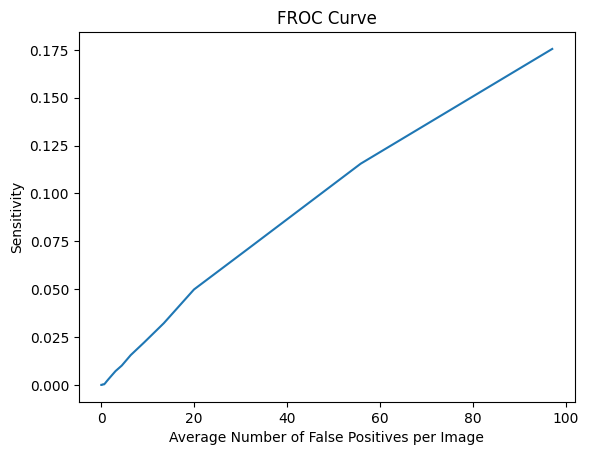

In [30]:
plt.plot(false_positives_per_image, sensitivities)
plt.xlabel("Average Number of False Positives per Image")
plt.ylabel("Sensitivity")
plt.title("FROC Curve")
plt.show()

In [31]:
# Methods for prediction for this competition
from math import ceil
from typing import Any, Dict, List

import cv2
import detectron2
import numpy as np
from numpy import ndarray
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer
from tqdm import tqdm


def format_pred(labels: ndarray, boxes: ndarray, scores: ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)


def predict_batch(predictor: DefaultPredictor, im_list: List[ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

In [11]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = '/content/drive/MyDrive/xray_dataset'
    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    use_class14: bool = False
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [18]:
flags_dict = {
    "debug": False,
    "imgdir_name": "train",
    "split_mode":  "all_train",
    "iter": 100,
    "roi_batch_size_per_image": 512,
    "eval_period": 100,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "num_workers": 4,
    "outdir": "output" ,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }

}



In [32]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

torch 2.2.1+cu121
flags Flags(debug=False, outdir='output', imgdir_name='train', split_mode='valid20', seed=111, train_data_type='original', use_class14=False, iter=20000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=256, eval_period=500, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 20, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}})


In [42]:
inputdir = Path('/content/drive/MyDrive/xray_dataset/')
traineddir = inputdir

# flags = Flags()
flags: Flags = Flags().update(load_yaml("output/flags.yaml"))
print("flags", flags)
debug = flags.debug
# flags_dict = dataclasses.asdict(flags)
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)

# --- Read data ---
datadir = inputdir
imgdir = inputdir

# Read in the data CSV files
# train = pd.read_csv(datadir / "train.csv")
test_meta = pd.read_csv(inputdir / "test_meta.csv")
sample_submission = pd.read_csv(datadir / "sample_submission.csv")

flags Flags(debug=False, outdir='output', imgdir_name='train', split_mode='all_train', seed=111, train_data_type='original', use_class14=False, iter=20000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=512, eval_period=500, aug_kwargs={'HorizontalFlip': {'p': 0.8}, 'RandomBrightnessContrast': {'p': 0.8}, 'ShiftScaleRotate': {'p': 0.8, 'rotate_limit': 20, 'scale_limit': 0.35}})


In [56]:
from detectron2.config import get_cfg
from detectron2.model_zoo import model_zoo  # Make sure this is correctly imported if used
import os
from detectron2.config.config import CfgNode as CN

def add_swint_config(cfg):
    from detectron2.config import CfgNode as CN
    # SwinT backbone
    cfg.MODEL.SWINT = CN()
    cfg.MODEL.SWINT.EMBED_DIM = 96
    cfg.MODEL.SWINT.OUT_FEATURES = ["stage2", "stage3", "stage4", "stage5"]
    cfg.MODEL.SWINT.DEPTHS = [2, 2, 6, 2]
    cfg.MODEL.SWINT.NUM_HEADS = [3, 6, 12, 24]
    cfg.MODEL.SWINT.WINDOW_SIZE = 7
    cfg.MODEL.SWINT.MLP_RATIO = 4
    cfg.MODEL.SWINT.DROP_PATH_RATE = 0.2
    cfg.MODEL.SWINT.APE = False
    cfg.MODEL.BACKBONE.FREEZE_AT = -1

    # Additional settings
    cfg.MODEL.FPN.TOP_LEVELS = 2
    cfg.SOLVER.OPTIMIZER = "AdamW"

# Initialize configuration and add custom SWINT settings
cfg = get_cfg()
add_swint_config(cfg)

# Configuration parameters from the script
original_output_dir = cfg.OUTPUT_DIR
outdir = "./" # Define outdir as needed
cfg.OUTPUT_DIR = "./"
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = os.path.join(imgdir, 'faster_rcnn_swint_T_FPN_3x.yaml')
cfg.merge_from_file(   os.path.join(imgdir, 'Base-RCNN-FPN.yaml')  )

cfg.DATASETS.TRAIN = ("vinbigdata_train",)
split_mode = flags_dict["split_mode"]  # Define split_mode as needed
if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("vinbigdata_valid",)
    cfg.TEST.EVAL_PERIOD = 400  # Example value, set as needed

# Assuming flags are defined elsewhere, make sure to properly define or replace `flags`
cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/xray_dataset/model_final.pth'
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.OUTPUT_DIR ./output -> ./


In [ ]:
get_vinbigdata_dicts_test(imgdir=inputdir, test_meta='content/drive/MyDrive/xray_dataset/test_meta.csv', use_cache= False, debug=debug)

In [33]:
# path to the model we just trained
cfg.MODEL.WEIGHTS =  'model_final.pth'
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
predictor = DefaultPredictor(cfg)


test_meta = pd.read_csv('/content/drive/MyDrive/xray_dataset/test_meta.csv')

DatasetCatalog.register(
    "vinbigdata_test", lambda: get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
)
MetadataCatalog.get("vinbigdata_test").set(thing_classes=thing_classes)
metadata = MetadataCatalog.get("vinbigdata_test")
dataset_dicts = get_vinbigdata_dicts_test(imgdir, test_meta, use_cache= False, debug=debug)

if debug:
    dataset_dicts = dataset_dicts[:100]

results_list = []
index = 0
batch_size = 4

Original thresh 0.05
Changed  thresh 0.0
[05/17 06:20:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model_final.pth ...
Creating data...
image shape: (256, 256, 3)


100%|██████████| 3000/3000 [00:00<00:00, 15475.86it/s]


Load from cache dataset_dicts_cache_test_debug0.pkl


In [59]:
from detectron2.data.catalog import DatasetCatalog
DatasetCatalog.remove("vinbigdata_test")

In [ ]:
import cv2
import os
from detectron2.utils.visualizer import Visualizer, ColorMode

# Assuming you have already defined the following variables:
# - predictor: the trained Detectron2 model
# - metadata: the metadata of the dataset
# - test_meta: a DataFrame containing image metadata
# - dataset_dicts: a list of dataset dictionaries

# Specify the index of the image you want to predict
index = 3

# Get the dataset dictionary for the specified image
d = dataset_dicts[index]

# Read the image using OpenCV
im = cv2.imread(d["file_name"])

# Perform prediction on the image
outputs = predictor(im)

# Create a Visualizer object
v = Visualizer(
    im[:, :, ::-1],
    metadata=metadata,
    scale=3,
    instance_mode=ColorMode.IMAGE_BW
)

# Draw the instance predictions on the image
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Get the output image
output_image = out.get_image()[:, :, ::-1]

# Specify the output directory and file name
outdir = "./"  # Replace with your output directory path
file_name = f"pred_{index}.jpg"
file_path = os.path.join(outdir, file_name)

# Save the output image using OpenCV
cv2.imwrite(file_path, output_image)

True

In [46]:
metrics_df = pd.read_json("metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,iteration,rpn/num_neg_anchors,rpn/num_pos_anchors,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,time,total_loss
0,0,231.00,25.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,233.25,22.75,0.004656,4070.484341,0.979980,1.000000,0.000000,1.419519,11.460713,1.674857,3.117327,1.986404e-05,0.004656,499.75,8.75,0.203728,17.715910
2,39,226.75,29.25,0.036394,4112.511354,0.975586,1.000000,0.000000,0.126571,1.979632,0.498048,0.360142,3.972092e-05,0.036394,499.50,12.50,0.216023,2.842754
3,59,229.75,26.25,0.005240,4131.884119,0.967773,1.000000,0.000000,0.103699,0.754502,0.326274,0.133503,5.957781e-05,0.005240,495.50,16.50,0.208874,1.461621
4,79,229.00,27.00,0.003462,4147.695857,0.970703,1.000000,0.000000,0.087492,0.418268,0.292053,0.118488,7.943469e-05,0.003462,497.00,15.00,0.212570,0.961278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,19919,232.25,23.75,0.004467,14.878020,0.941406,0.577011,0.378409,0.209760,0.230994,0.104987,0.050043,4.047100e-08,0.004467,469.50,42.50,0.184969,0.638597
997,19939,229.00,27.00,0.004465,11.158515,0.931152,0.589916,0.396698,0.231632,0.255278,0.084490,0.044808,2.295282e-08,0.004465,461.50,50.50,0.185731,0.687995
998,19959,229.75,26.25,0.004569,7.439557,0.931641,0.633511,0.366489,0.244452,0.243211,0.082186,0.046675,1.036922e-08,0.004569,460.75,51.25,0.188899,0.617186
999,19979,232.75,23.25,0.004447,3.718988,0.949219,0.485853,0.514147,0.168819,0.200431,0.089490,0.037314,2.720307e-09,0.004447,469.25,42.75,0.182688,0.489187


In [34]:

for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
        if index < 5:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            im_list = cv2.imread(d["file_name"])
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=5,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # cv2_imshow(out.get_image()[:, :, ::-1])
            import os

            outdir = "./"  # Replace with your output directory path

            file_name = f"pred_{index}.jpg"
            file_path = os.path.join(outdir, file_name)
            cv2.imwrite(file_path, out.get_image()[:, :, ::-1])

        image_id, dim0, dim1 = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 1 0 0 1 1x.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()

            result = {
                "image_id": image_id,
                "PredictionString": format_pred(
                    pred_classes_array, pred_boxes_array, pred_scores_array
                ),
            }
        results_list.append(result)
        index += 1

100%|██████████| 750/750 [22:38<00:00,  1.81s/it]


In [35]:
submission_det = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
submission_det.to_csv("submission.csv", index=False)
submission_det

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,9 0.6601070165634155 1243 8 1932 1543 9 0.6361...
1,004f33259ee4aef671c2b95d54e4be68,9 0.5929473638534546 1306 0 2193 1537 9 0.5608...
2,008bdde2af2462e86fd373a445d0f4cd,9 0.8696616291999817 1547 8 2097 1838 9 0.8581...
3,009bc039326338823ca3aa84381f17f1,9 0.6885855197906494 1011 0 1738 1255 9 0.6348...
4,00a2145de1886cb9eb88869c85d74080,9 0.7446286678314209 990 7 2133 708 9 0.720957...
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,9 0.6077341437339783 111 1122 575 2447 9 0.593...
2996,ff9fcc4087ed5e941209aa3fa948e364,9 0.5257217884063721 1248 47 1840 1595 13 0.51...
2997,ffaa288c8abca300974f043b57d81521,13 0.670952558517456 182 1198 1040 1644 13 0.6...
2998,ffc441e0c8b7153844047483a577e7c3,9 0.7129678726196289 878 3 1944 678 9 0.518355...
